In [1]:
"""
Author: Qiaochu Zhang
"""
%pylab inline
import pandas as pd
from pandas import Series, DataFrame
import os
import gc
import glob
import re
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division #c++ style division, no rounding
from scipy import stats
import copy
mpl.rcParams['axes.unicode_minus'] = False 
mpl.rcParams['axes.grid'] = True
plt.rc('figure', figsize=(13, 7))
plt.style.use('ggplot')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_columns",999)
def ht(df, n = 5):
    print df.shape
    if len(df) <= 2*n:
        display(df)
    else:
        display(df.head(n).append(df.tail(n)))
def print_full(df):
    pd.set_option('display.max_rows', len(df))
    display(df)
    pd.reset_option('display.max_rows')
def FloatFormatOn():
    pd.options.display.float_format = '{:,.3f}'.format
def FloatFormatOff():
    pd.options.display.float_format = '{:f}'.format    
def PlotDistribution(data, output_location=None):
    plt.subplot(2, 2, 1)
    sns.boxplot(data, orient='v')
    plt.subplot(2, 2, 2)
    sns.distplot(data, bins=100)
    ax = plt.subplot(2, 1, 2)
    stats.probplot(data, dist=stats.norm, plot=ax)
    if output_location is not None: plt.savefig(output_location, bbox_inches='tight', pad_inches=0.1)
    plt.show()    
import sys
print(sys.version)
print(pd.__version__)
print(np.__version__)

Populating the interactive namespace from numpy and matplotlib
2.7.13 |Anaconda custom (64-bit)| (default, May 11 2017, 13:17:26) [MSC v.1500 64 bit (AMD64)]
0.20.3
1.12.1


In [278]:
import xgboost as xgb

import sklearn
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.datasets import load_boston

In [3]:
rng = np.random.RandomState(31337)

In [4]:
print("Boston Housing: regression")
boston = load_boston()

Boston Housing: regression


In [5]:
print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [6]:
dfData=pd.DataFrame(data=boston['data'], columns=boston.feature_names)
dfTarget=pd.Series(data=boston['target'])

In [7]:
ht(dfData)

(506, 13)


CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  
0       15.3  396.90   4.98  
1       17.8  396.90   9.14  
2       17.8  392.83   4.03  
3       18.7  394.63   2.94  
4       18.7  396.90   5.33  
501     21.0  391.99   9.67  
502     21.0  396.90   9.08  
503     21.0  396.90   5.64  
504     21.0  393.45   6.48  
505     21.0  396.90   7.88

In [8]:
ht(dfTarget)

(506L,)


0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
dtype: float64

In [9]:
PlotDistribution(dfTarget)

In [132]:
dfTarget.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
dtype: float64

### Parmeter Tuning

In [10]:
dfTrain, dfTest, dfTrainLabel, dfTestLabel = train_test_split(dfData, dfTarget, test_size = 0.2, random_state = rng)

In [11]:
print dfTrain.shape
print dfTrainLabel.shape
print dfTest.shape
print dfTestLabel.shape

(404, 13)
(404L,)
(102, 13)
(102L,)


In [36]:
DData=xgb.DMatrix(dfTrain, label=dfTrainLabel, feature_names=dfTrain.columns)

In [152]:
def run_model_report(param, dmat):
    dfCVResult=xgb.cv(param, dmat, metrics=['rmse'],
                      nfold=5, early_stopping_rounds=50, num_boost_round=1000, verbose_eval=False)    
    ht(dfCVResult)
    dfCVResult[['test-rmse-mean', 'train-rmse-mean']].plot(); plt.show()
    
    n_estimators=len(dfCVResult)
    new_param=param.copy()
    new_param['n_estimators']=n_estimators
    model=xgb.XGBRegressor(**new_param)
    model.fit(dfTrain, dfTrainLabel)
    print model
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,30)) 
    xgb.plot_tree(model, num_trees=0, ax=axes[0])               # First tree
    xgb.plot_tree(model, num_trees=n_estimators-1, ax=axes[1])  # Last tree
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,7)) 
    xgb.plot_importance(model, importance_type='gain', ax=ax)
    plt.show()    

In [130]:
def RMSE(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return rmse
scorer = make_scorer(RMSE, greater_is_better=False)

    0. default parameters

In [144]:
model=xgb.XGBRegressor()
model.fit(dfTrain, dfTrainLabel)
predictions = model.predict(dfTest)
actuals = dfTestLabel
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.75099156763


(244, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         21.224274       0.931194        21.224027        0.212779
1         19.283827       0.900478        19.233934        0.192719
2         17.535321       0.863987        17.439015        0.172265
3         15.954972       0.816267        15.825505        0.157523
4         14.547360       0.770883        14.372557        0.143266
239        3.263546       0.338415         0.718380        0.035702
240        3.261683       0.338602         0.715797        0.036295
241        3.261826       0.338403         0.713046        0.035001
242        3.261618       0.341308         0.709581        0.034925
243        3.261406       0.342052         0.707386        0.034967

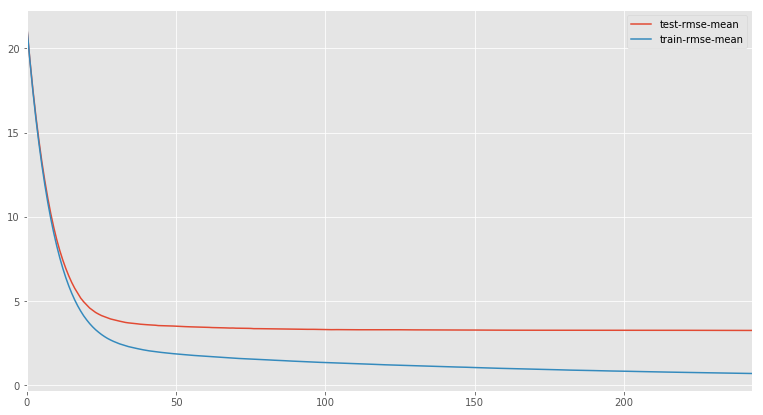

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=244,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [153]:
run_model_report(param={
    'learning_rate':0.1,
    'max_depth':3,
    'min_child_weight':1,
    'gamma':0,
    'objective':'reg:linear'}, dmat=DData)

    1. max_depth

In [99]:
param={'learning_rate':0.1,
       'n_estimators':244,
       'max_depth':3,
       'min_child_weight':0,
       'gamma':0,
       'objective':'reg:linear'}
param_test = {
 'max_depth':range(1,10,1)
}
gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**param), 
                       param_grid=param_test, 
                       n_jobs=1, cv=5, verbose=1, scoring=scorer)
gsearch.fit(dfTrain,dfTrainLabel)
print gsearch.best_params_
print gsearch.best_score_
display(DataFrame(gsearch.cv_results_).sort_values(by='mean_test_score', ascending=False).head())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_depth': 3}
-3.4686032047


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.1s finished


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
2         0.0770           0.0000        -3.468603         -0.703527   
3         0.1006           0.0004        -3.476448         -0.293036   
1         0.0510           0.0004        -3.504768         -1.367697   
8         0.2120           0.0020        -3.521849         -0.001134   
6         0.1830           0.0030        -3.523853         -0.009841   

  param_max_depth             params  rank_test_score  split0_test_score  \
2               3  {u'max_depth': 3}                1          -5.921533   
3               4  {u'max_depth': 4}                2          -5.635848   
1               2  {u'max_depth': 2}                3          -6.015280   
8               9  {u'max_depth': 9}                4          -5.960409   
6               7  {u'max_depth': 7}                5          -5.909636   

   split0_train_score  split1_test_score  split1_train_score  \
2           -0.698919          -2.484293           -0.717567   
3           -0.317690          -2.458894           -0.293729   
1           -1.310001          -2.701490           -1.381593   
8           -0.001180          -2.371184           -0.001095   
6           -0.007547          -2.338880           -0.009658   

   split2_test_score  split2_train_score  split3_test_score  \
2          -3.107311           -0.742845          -3.215887   
3          -3.201433           -0.299785          -3.228167   
1          -2.761234           -1.360385          -3.133575   
8          -3.041718           -0.001151          -3.263241   
6          -2.946014           -0.008118          -3.398622   

   split3_train_score  split4_test_score  split4_train_score  std_fit_time  \
2           -0.677015          -2.603308           -0.681291      0.010954   
3           -0.275309          -2.850166           -0.278666      0.012076   
1           -1.409370          -2.904857           -1.377136      0.009654   
8           -0.001091          -2.965829           -0.001152      0.011610   
6           -0.007994          -3.019892           -0.015887      0.008944   

   std_score_time  std_test_score  std_train_score  
2        0.000000        1.260097         0.024338  
3        0.000490        1.117004         0.015327  
1        0.000490        1.266001         0.032867  
8        0.001673        1.256411         0.000035  
6        0.002000        1.242224         0.003106

    2. min_child_weight

In [100]:
param={'learning_rate':0.1,
       'n_estimators':244,
       'max_depth':3,
       'min_child_weight':1,
       'gamma':0,
       'objective':'reg:linear'}
param_test = {
 'min_child_weight':np.linspace(0.0,1.0,20)
}
gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**param), 
                       param_grid=param_test, 
                       n_jobs=1, cv=5, verbose=1, scoring=scorer, )
gsearch.fit(dfTrain,dfTrainLabel)
print gsearch.best_params_
print gsearch.best_score_
display(DataFrame(gsearch.cv_results_).sort_values(by='mean_test_score', ascending=False).head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'min_child_weight': 0.0}
-3.4686032047


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.9s finished


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0          0.0802           0.0010        -3.468603         -0.703527   
1          0.0714           0.0006        -3.468603         -0.703527   
18         0.0826           0.0002        -3.468603         -0.703527   
17         0.0780           0.0004        -3.468603         -0.703527   
16         0.0752           0.0000        -3.468603         -0.703527   

   param_min_child_weight                                  params  \
0                       0              {u'min_child_weight': 0.0}   
1               0.0526316  {u'min_child_weight': 0.0526315789474}   
18               0.947368   {u'min_child_weight': 0.947368421053}   
17               0.894737   {u'min_child_weight': 0.894736842105}   
16               0.842105   {u'min_child_weight': 0.842105263158}   

    rank_test_score  split0_test_score  split0_train_score  split1_test_score  \
0                 1          -5.921533           -0.698919          -2.484293   
1                 1          -5.921533           -0.698919          -2.484293   
18                1          -5.921533           -0.698919          -2.484293   
17                1          -5.921533           -0.698919          -2.484293   
16                1          -5.921533           -0.698919          -2.484293   

    split1_train_score  split2_test_score  split2_train_score  \
0            -0.717567          -3.107311           -0.742845   
1            -0.717567          -3.107311           -0.742845   
18           -0.717567          -3.107311           -0.742845   
17           -0.717567          -3.107311           -0.742845   
16           -0.717567          -3.107311           -0.742845   

    split3_test_score  split3_train_score  split4_test_score  \
0           -3.215887           -0.677015          -2.603308   
1           -3.215887           -0.677015          -2.603308   
18          -3.215887           -0.677015          -2.603308   
17          -3.215887           -0.677015          -2.603308   
16          -3.215887           -0.677015          -2.603308   

    split4_train_score  std_fit_time  std_score_time  std_test_score  \
0            -0.681291      0.010323        0.000894        1.260097   
1            -0.681291      0.011977        0.000800        1.260097   
18           -0.681291      0.007579        0.000400        1.260097   
17           -0.681291      0.013871        0.000800        1.260097   
16           -0.681291      0.011565        0.000000        1.260097   

    std_train_score  
0          0.024338  
1          0.024338  
18         0.024338  
17         0.024338  
16         0.024338

(244, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         21.224274       0.931194        21.224027        0.212779
1         19.283827       0.900478        19.233934        0.192719
2         17.535321       0.863987        17.439015        0.172265
3         15.954972       0.816267        15.825505        0.157523
4         14.547360       0.770883        14.372557        0.143266
239        3.263546       0.338415         0.718380        0.035702
240        3.261683       0.338602         0.715797        0.036295
241        3.261826       0.338403         0.713046        0.035001
242        3.261618       0.341308         0.709581        0.034925
243        3.261406       0.342052         0.707386        0.034967

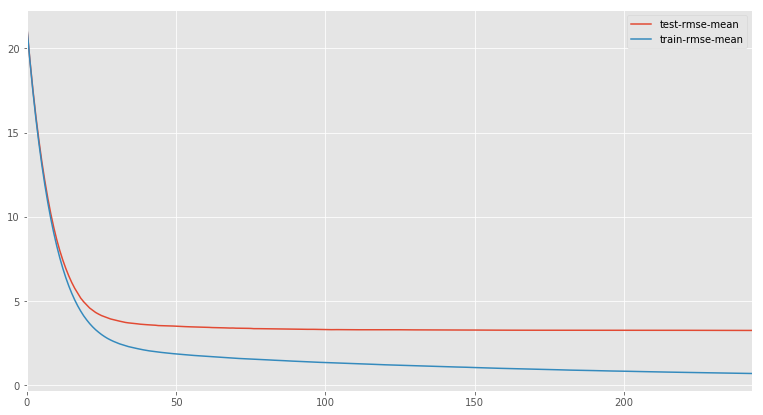

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=244,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [154]:
run_model_report(param={
    'learning_rate':0.1,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear'}, dmat=DData)

    3. gamma

In [101]:
param={'learning_rate':0.1,
       'n_estimators':244,
       'max_depth':3,
       'min_child_weight':0,
       'gamma':0,
       'objective':'reg:linear'}
param_test = {
 'gamma':np.linspace(0.0,1.0,20)
}
gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**param), 
                       param_grid=param_test, 
                       n_jobs=1, cv=5, verbose=1, scoring=scorer, )
gsearch.fit(dfTrain,dfTrainLabel)
print gsearch.best_params_
print gsearch.best_score_
display(DataFrame(gsearch.cv_results_).sort_values(by='mean_test_score', ascending=False).head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'gamma': 0.0}
-3.4686032047


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.2s finished


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0         0.0804           0.0006        -3.468603         -0.703527   
1         0.0744           0.0002        -3.468739         -0.701842   
3         0.0736           0.0008        -3.469815         -0.691050   
7         0.0886           0.0008        -3.476271         -0.684460   
2         0.0778           0.0012        -3.485474         -0.704120   

  param_gamma                       params  rank_test_score  \
0           0              {u'gamma': 0.0}                1   
1   0.0526316  {u'gamma': 0.0526315789474}                2   
3    0.157895   {u'gamma': 0.157894736842}                3   
7    0.368421   {u'gamma': 0.368421052632}                4   
2    0.105263   {u'gamma': 0.105263157895}                5   

   split0_test_score  split0_train_score  split1_test_score  \
0          -5.921533           -0.698919          -2.484293   
1          -5.924092           -0.719706          -2.491812   
3          -5.940416           -0.706085          -2.472313   
7          -5.898039           -0.688470          -2.499411   
2          -5.953143           -0.704902          -2.515100   

   split1_train_score  split2_test_score  split2_train_score  \
0           -0.717567          -3.107311           -0.742845   
1           -0.690074          -3.076826           -0.726449   
3           -0.704521          -3.088905           -0.697360   
7           -0.672898          -3.069039           -0.687960   
2           -0.730259          -3.088467           -0.711094   

   split3_test_score  split3_train_score  split4_test_score  \
0          -3.215887           -0.677015          -2.603308   
1          -3.239003           -0.683585          -2.601256   
3          -3.225919           -0.660998          -2.610918   
7          -3.221963           -0.682974          -2.683110   
2          -3.236609           -0.696032          -2.623406   

   split4_train_score  std_fit_time  std_score_time  std_test_score  \
0           -0.681291      0.011775        0.000800        1.260097   
1           -0.689398      0.012010        0.000400        1.261142   
3           -0.686284      0.008868        0.000748        1.269011   
7           -0.689999      0.006406        0.000748        1.240166   
2           -0.678312      0.001327        0.000748        1.265252   

   std_train_score  
0         0.024338  
1         0.017614  
3         0.016572  
7         0.006243  
2         0.017111

    4. subsample

In [106]:
param={'learning_rate':0.1,
       'n_estimators':347,
       'max_depth':3,
       'min_child_weight':0,
       'gamma':0,
       'objective':'reg:linear'}
param_test = {
 'subsample':np.linspace(0.8,0.9,20)
}
gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**param), 
                       param_grid=param_test, 
                       n_jobs=1, cv=5, verbose=1, scoring=scorer, )
gsearch.fit(dfTrain,dfTrainLabel)
print gsearch.best_params_
print gsearch.best_score_
display(DataFrame(gsearch.cv_results_).sort_values(by='mean_test_score', ascending=False).head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'subsample': 0.88421052631578956}
-3.35488021985


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.0s finished


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
16         0.1070           0.0002        -3.354880         -0.423183   
9          0.1124           0.0002        -3.360402         -0.420214   
6          0.1186           0.0004        -3.372444         -0.420052   
17         0.1142           0.0060        -3.373815         -0.414986   
14         0.1098           0.0002        -3.382730         -0.411461   

   param_subsample                          params  rank_test_score  \
16        0.884211  {u'subsample': 0.884210526316}                1   
9         0.847368  {u'subsample': 0.847368421053}                2   
6         0.831579  {u'subsample': 0.831578947368}                3   
17        0.889474  {u'subsample': 0.889473684211}                4   
14        0.873684  {u'subsample': 0.873684210526}                5   

    split0_test_score  split0_train_score  split1_test_score  \
16          -5.836205           -0.421940          -2.459137   
9           -5.802566           -0.410522          -2.548451   
6           -5.686521           -0.403191          -2.385350   
17          -5.824956           -0.417871          -2.640876   
14          -5.810542           -0.417058          -2.465576   

    split1_train_score  split2_test_score  split2_train_score  \
16           -0.409489          -3.015164           -0.430043   
9            -0.460466          -3.051327           -0.422823   
6            -0.437416          -3.136138           -0.417717   
17           -0.419974          -2.898656           -0.404243   
14           -0.415541          -3.138655           -0.401800   

    split3_test_score  split3_train_score  split4_test_score  \
16          -2.969112           -0.434270          -2.484032   
9           -2.890726           -0.392395          -2.498297   
6           -3.025620           -0.400545          -2.619293   
17          -2.897490           -0.418217          -2.597513   
14          -2.819770           -0.411732          -2.670312   

    split4_train_score  std_fit_time  std_score_time  std_test_score  \
16           -0.420174      0.008270        0.000400        1.264302   
9            -0.414864      0.015743        0.000400        1.240371   
6            -0.441393      0.017557        0.000490        1.190223   
17           -0.414627      0.007833        0.007349        1.233852   
14           -0.411172      0.002315        0.000400        1.235480   

    std_train_score  
16         0.008580  
9          0.022466  
6          0.016895  
17         0.005642  
14         0.005319

(347, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         21.264789       0.931542        21.242554        0.214973
1         19.334684       0.908027        19.260967        0.200211
2         17.580940       0.877959        17.477188        0.183115
3         15.984830       0.822711        15.864380        0.172846
4         14.552726       0.786425        14.411588        0.162726
342        3.224232       0.440243         0.422992        0.032232
343        3.223976       0.439643         0.421024        0.032089
344        3.224267       0.439288         0.420073        0.031609
345        3.224015       0.438742         0.418469        0.031884
346        3.222418       0.439807         0.416110        0.031866

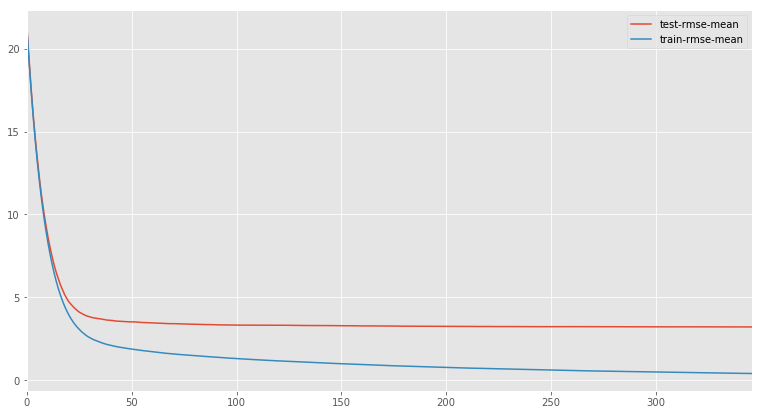

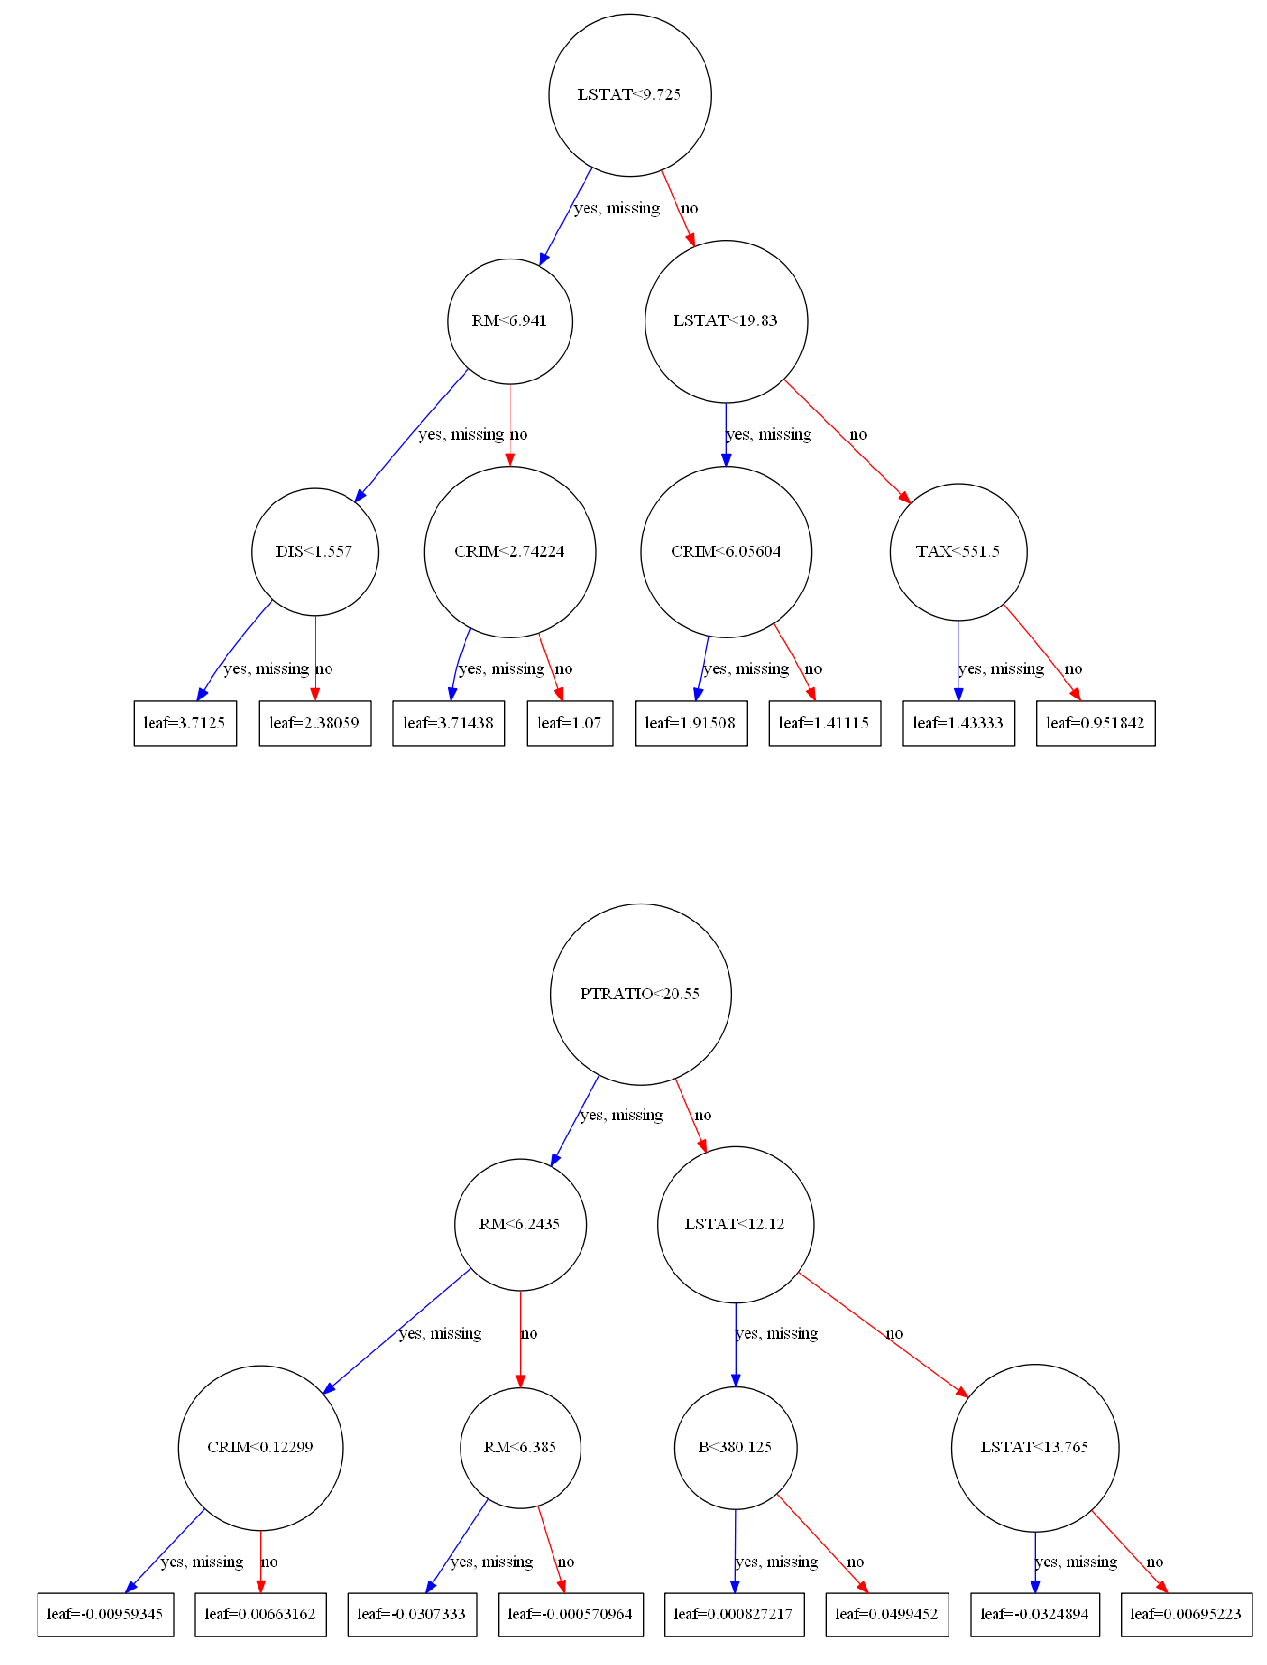

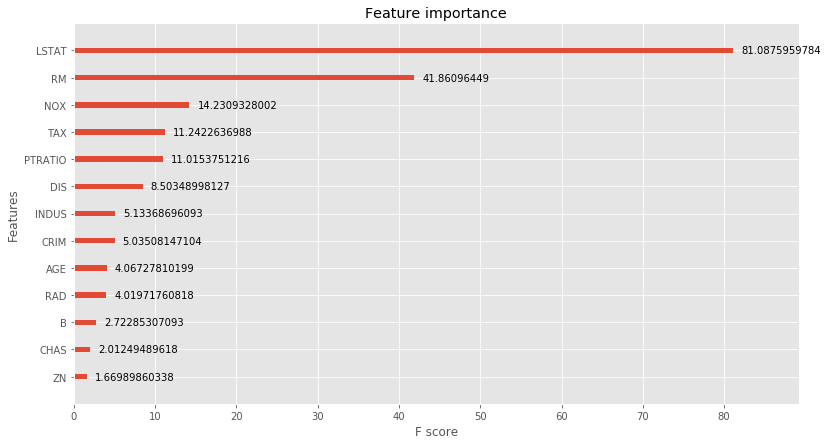

In [105]:
run_model_report(param={
    'learning_rate':0.1,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
}, dmat=DData)

    5. colsample_bytree

In [112]:
param={
    'learning_rate':0.1,
    'n_estimators':347,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
}
param_test = {
 'colsample_bytree':np.linspace(0.9,1.0,20)
}
gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**param), 
                       param_grid=param_test, 
                       n_jobs=1, cv=5, verbose=1, scoring=scorer)
gsearch.fit(dfTrain,dfTrainLabel)
print gsearch.best_params_
print gsearch.best_score_
display(DataFrame(gsearch.cv_results_).sort_values(by='mean_test_score', ascending=False).head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'colsample_bytree': 0.9263157894736842}
-3.34847518222


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.9s finished


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
10         0.0990           0.0006        -3.348475         -0.428971   
14         0.0996           0.0000        -3.348475         -0.428971   
18         0.0980           0.0030        -3.348475         -0.428971   
17         0.1048           0.0030        -3.348475         -0.428971   
16         0.1032           0.0000        -3.348475         -0.428971   

   param_colsample_bytree                                 params  \
10               0.952632  {u'colsample_bytree': 0.952631578947}   
14               0.973684  {u'colsample_bytree': 0.973684210526}   
18               0.994737  {u'colsample_bytree': 0.994736842105}   
17               0.989474  {u'colsample_bytree': 0.989473684211}   
16               0.984211  {u'colsample_bytree': 0.984210526316}   

    rank_test_score  split0_test_score  split0_train_score  split1_test_score  \
10                1          -5.575131           -0.441436           -2.48446   
14                1          -5.575131           -0.441436           -2.48446   
18                1          -5.575131           -0.441436           -2.48446   
17                1          -5.575131           -0.441436           -2.48446   
16                1          -5.575131           -0.441436           -2.48446   

    split1_train_score  split2_test_score  split2_train_score  \
10           -0.422217          -3.015772           -0.437235   
14           -0.422217          -3.015772           -0.437235   
18           -0.422217          -3.015772           -0.437235   
17           -0.422217          -3.015772           -0.437235   
16           -0.422217          -3.015772           -0.437235   

    split3_test_score  split3_train_score  split4_test_score  \
10          -3.078736           -0.433168          -2.578775   
14          -3.078736           -0.433168          -2.578775   
18          -3.078736           -0.433168          -2.578775   
17          -3.078736           -0.433168          -2.578775   
16          -3.078736           -0.433168          -2.578775   

    split4_train_score  std_fit_time  std_score_time  std_test_score  \
10           -0.410797      0.010296          0.0008        1.139221   
14           -0.410797      0.007710          0.0000        1.139221   
18           -0.410797      0.006356          0.0060        1.139221   
17           -0.410797      0.007026          0.0060        1.139221   
16           -0.410797      0.007935          0.0000        1.139221   

    std_train_score  
10          0.01111  
14          0.01111  
18          0.01111  
17          0.01111  
16          0.01111

(333, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         21.259158       0.906109        21.243017        0.216516
1         19.297570       0.902105        19.256358        0.196069
2         17.540936       0.869652        17.471511        0.179194
3         15.938201       0.819982        15.860868        0.171491
4         14.511556       0.789260        14.407515        0.159980
328        3.291195       0.344742         0.462334        0.032285
329        3.291011       0.344721         0.461188        0.032196
330        3.290059       0.344797         0.459666        0.032616
331        3.289962       0.345099         0.457258        0.031850
332        3.289568       0.345010         0.455628        0.032508

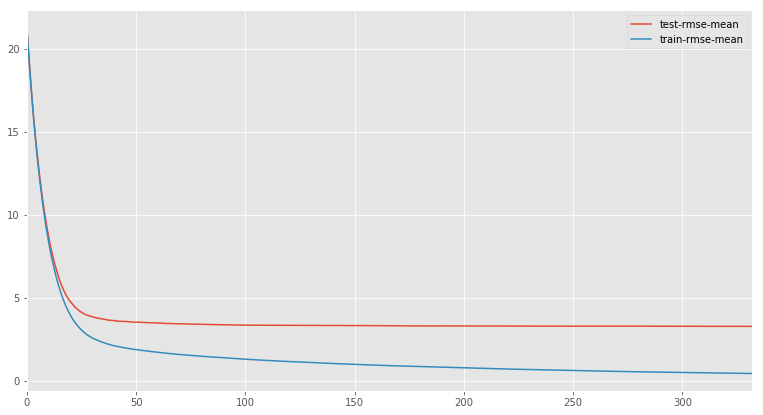

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.925, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=0, missing=None,
       n_estimators=333, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.885)


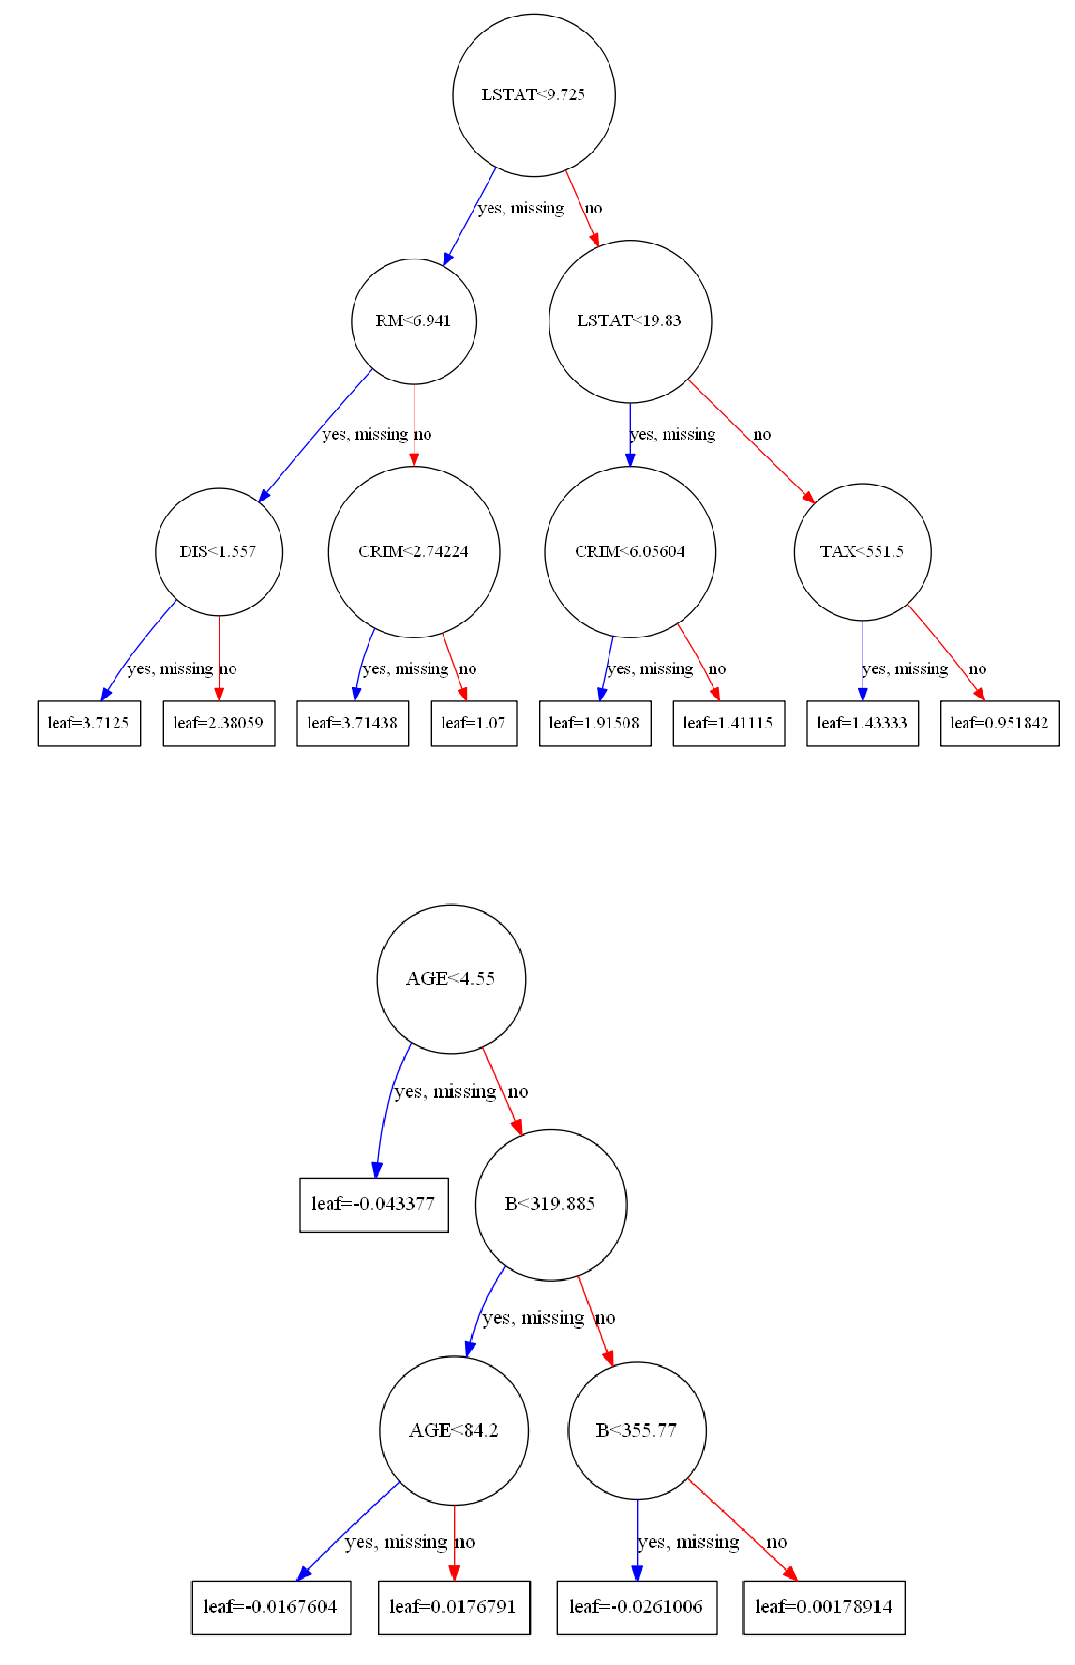

In [155]:
run_model_report(param={
    'learning_rate':0.1,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'colsample_bytree':0.925
}, dmat=DData)

    6. reg_lambda

In [121]:
param={
    'learning_rate':0.1,
    'n_estimators':526,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
}
param_test = {
 'reg_lambda':np.linspace(0.0,0.01,20)
}
gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**param), 
                       param_grid=param_test, 
                       n_jobs=1, cv=5, verbose=1, scoring=scorer)
gsearch.fit(dfTrain,dfTrainLabel)
print gsearch.best_params_
print gsearch.best_score_
display(DataFrame(gsearch.cv_results_).sort_values(by='mean_test_score', ascending=False).head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.5s finished


{'reg_lambda': 0.005263157894736842}
-3.31129723453


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
10         0.1426           0.0004        -3.311297         -0.149437   
9          0.1500           0.0008        -3.311797         -0.148830   
12         0.1524           0.0008        -3.332236         -0.153419   
11         0.1518           0.0040        -3.336136         -0.150594   
3          0.1462           0.0008        -3.336602         -0.149325   

   param_reg_lambda                             params  rank_test_score  \
10       0.00526316  {u'reg_lambda': 0.00526315789474}                1   
9        0.00473684  {u'reg_lambda': 0.00473684210526}                2   
12       0.00631579  {u'reg_lambda': 0.00631578947368}                3   
11       0.00578947  {u'reg_lambda': 0.00578947368421}                4   
3        0.00157895  {u'reg_lambda': 0.00157894736842}                5   

    split0_test_score  split0_train_score  split1_test_score  \
10          -5.891742           -0.153338          -2.416982   
9           -5.871073           -0.152582          -2.412899   
12          -5.876318           -0.152627          -2.453789   
11          -5.879377           -0.152462          -2.409502   
3           -5.964149           -0.157004          -2.410810   

    split1_train_score  split2_test_score  split2_train_score  \
10           -0.163957          -2.610221           -0.134621   
9            -0.153413          -2.609386           -0.135833   
12           -0.161484          -2.642274           -0.143833   
11           -0.154100          -2.677943           -0.131600   
3            -0.146494          -2.708582           -0.137600   

    split3_test_score  split3_train_score  split4_test_score  \
10          -3.200454           -0.150868          -2.426159   
9           -3.220605           -0.152820          -2.434185   
12          -3.235498           -0.145889          -2.442316   
11          -3.262354           -0.148111          -2.440447   
3           -3.211236           -0.156846          -2.376375   

    split4_train_score  std_fit_time  std_score_time  std_test_score  \
10           -0.144400      0.003774         0.00080        1.323458   
9            -0.149499      0.013755         0.00098        1.314659   
12           -0.163263      0.006468         0.00098        1.306344   
11           -0.166695      0.012432         0.00555        1.309880   
3            -0.148683      0.010572         0.00098        1.349396   

    std_train_score  
10         0.009726  
9          0.006639  
12         0.007889  
11         0.011331  
3          0.007231

(526, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         21.189352       0.884883        21.169875        0.211892
1         19.189567       0.800921        19.124025        0.195316
2         17.366607       0.727825        17.283234        0.180536
3         15.732829       0.660081        15.627533        0.175967
4         14.295379       0.582369        14.144477        0.158550
521        3.196731       0.430075         0.149820        0.010836
522        3.196602       0.429639         0.149174        0.010935
523        3.196532       0.429531         0.148417        0.010804
524        3.196559       0.429264         0.147632        0.010683
525        3.196350       0.429340         0.146919        0.010777

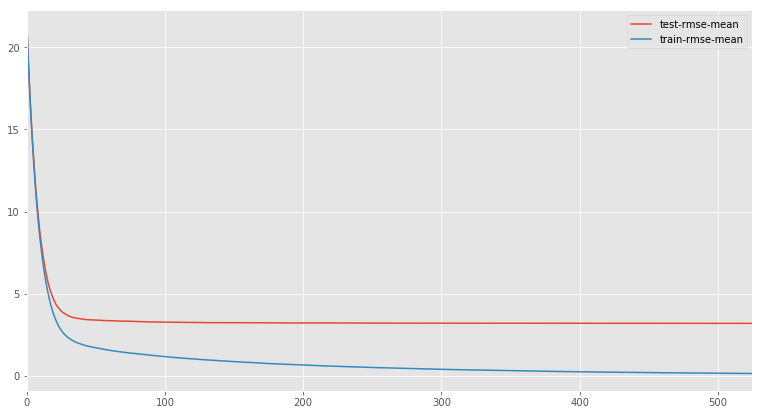

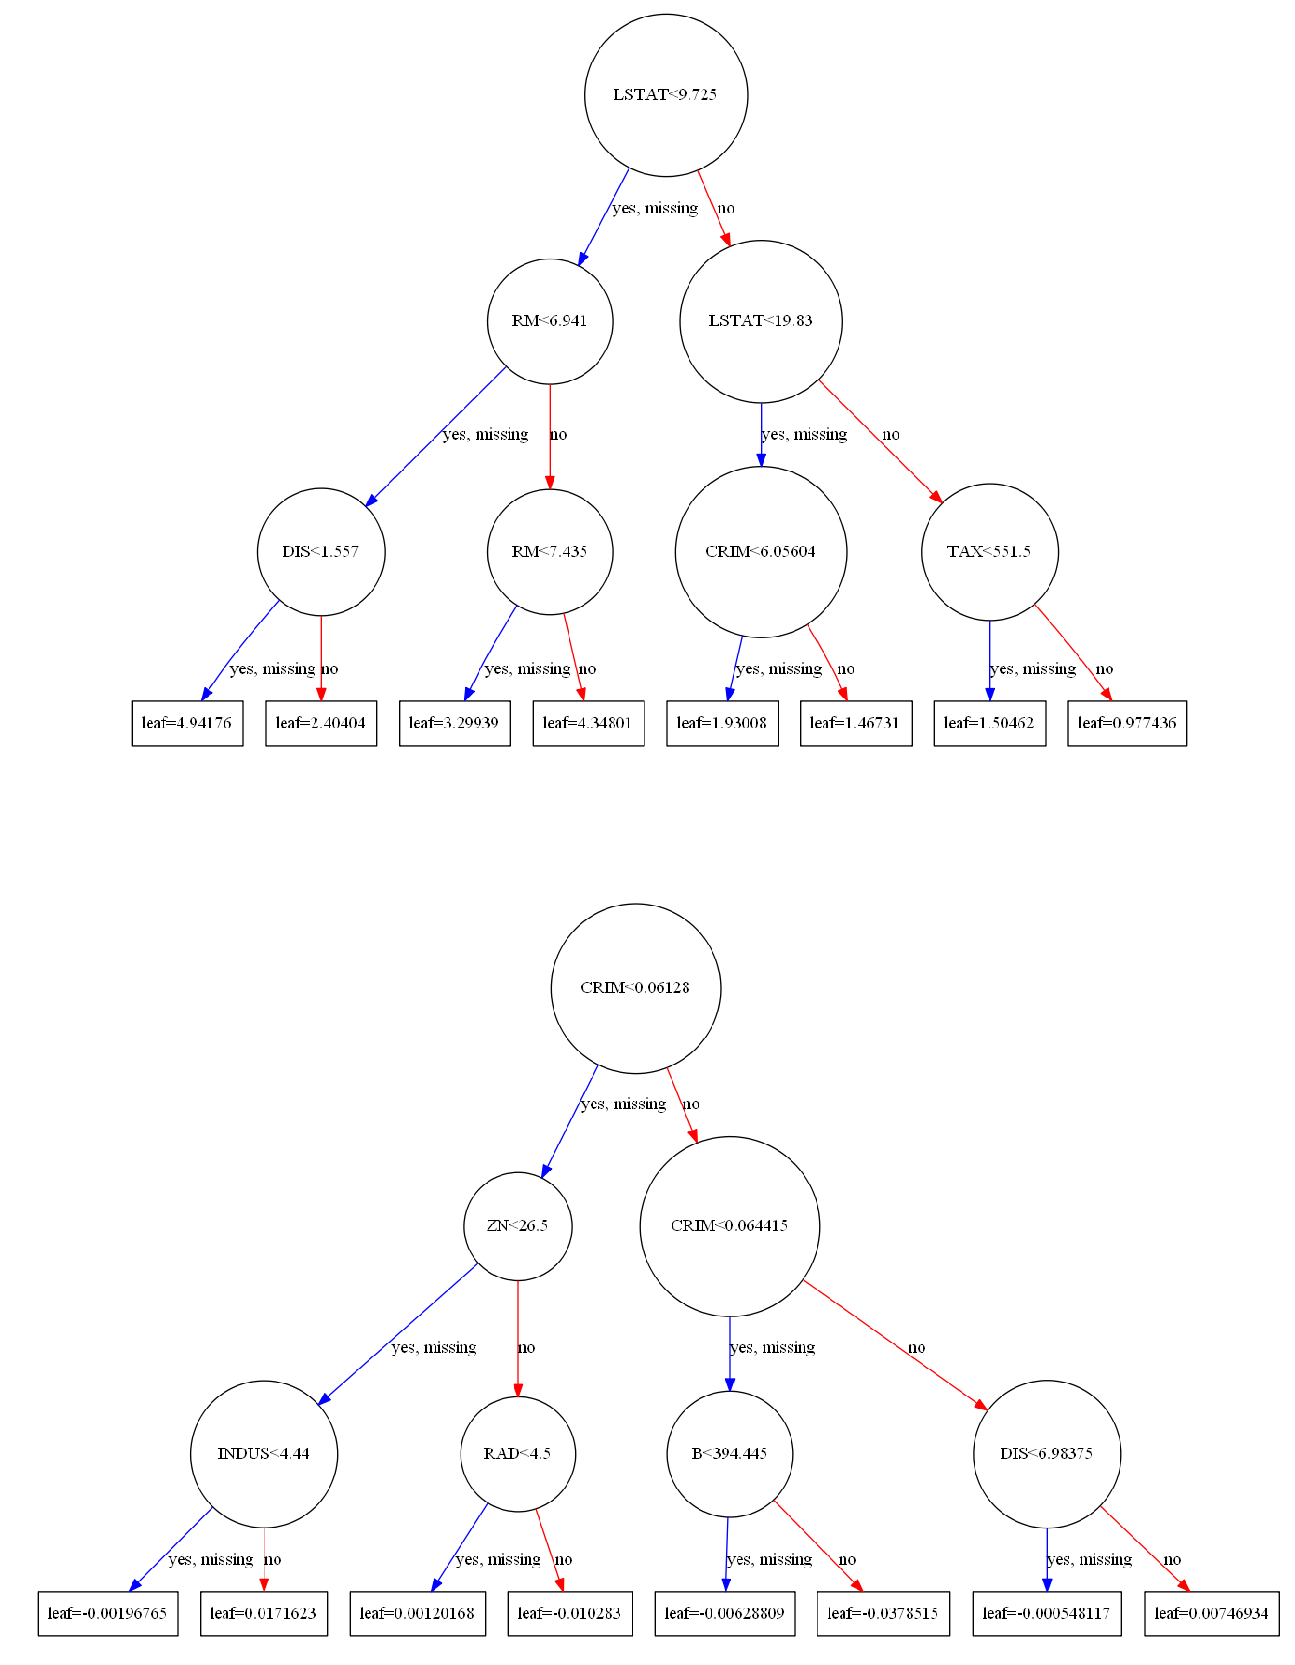

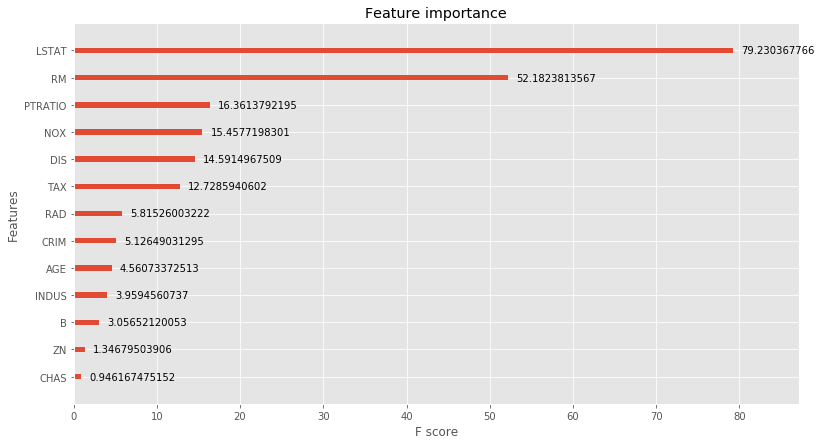

In [120]:
run_model_report(param={
    'learning_rate':0.1,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005
}, dmat=DData)

    7. learning_rate

In [129]:
param={
    'learning_rate':0.1,
    'n_estimators':266,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005
}
param_test = {
 'learning_rate':np.linspace(0.05,0.2,20)
}
gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**param), 
                       param_grid=param_test, 
                       n_jobs=1, cv=5, verbose=1, scoring=scorer)
gsearch.fit(dfTrain,dfTrainLabel)
print gsearch.best_params_
print gsearch.best_score_
display(DataFrame(gsearch.cv_results_).sort_values(by='mean_test_score', ascending=False).head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'learning_rate': 0.12105263157894738}
-3.32476900399


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.9s finished


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
9          0.0722           0.0000        -3.324769         -0.358346   
8          0.0648           0.0060        -3.346795         -0.417749   
0          0.0816           0.0008        -3.356625         -0.942022   
10         0.0782           0.0000        -3.375441         -0.333935   
15         0.0688           0.0060        -3.384005         -0.207630   

   param_learning_rate                              params  rank_test_score  \
9             0.121053  {u'learning_rate': 0.121052631579}                1   
8             0.113158  {u'learning_rate': 0.113157894737}                2   
0                 0.05            {u'learning_rate': 0.05}                3   
10            0.128947  {u'learning_rate': 0.128947368421}                4   
15            0.168421  {u'learning_rate': 0.168421052632}                5   

    split0_test_score  split0_train_score  split1_test_score  \
9           -5.744973           -0.355322          -2.502408   
8           -5.699599           -0.414537          -2.459450   
0           -5.760627           -0.937511          -2.514347   
10          -5.721699           -0.317096          -2.499148   
15          -5.613413           -0.217345          -2.512422   

    split1_train_score  split2_test_score  split2_train_score  \
9            -0.347672          -2.889306           -0.341444   
8            -0.449274          -2.885979           -0.388865   
0            -0.989775          -2.882626           -0.953110   
10           -0.338423          -2.952677           -0.341559   
15           -0.204089          -2.993263           -0.204898   

    split3_test_score  split3_train_score  split4_test_score  \
9           -3.088351           -0.359481          -2.387232   
8           -3.239532           -0.419967          -2.438198   
0           -3.136245           -0.920347          -2.478437   
10          -3.234462           -0.323199          -2.457893   
15          -3.306899           -0.195292          -2.482901   

    split4_train_score  std_fit_time  std_score_time  std_test_score  \
9            -0.387811      0.005946        0.000000        1.238244   
8            -0.416103      0.003600        0.007348        1.214949   
0            -0.909368      0.009243        0.000980        1.228187   
10           -0.349400      0.000400        0.000000        1.210041   
15           -0.216525      0.006274        0.007348        1.158194   

    std_train_score  
9          0.015989  
8          0.019215  
0          0.028142  
10         0.011969  
15         0.008315

(266, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         20.744337       0.877421        20.717855        0.207138
1         18.401370       0.778964        18.318955        0.188018
2         16.316617       0.694062        16.209047        0.170544
3         14.485071       0.620085        14.352938        0.164413
4         12.900555       0.555975        12.726059        0.143593
261        3.151366       0.447301         0.386841        0.023396
262        3.150875       0.447770         0.384664        0.023283
263        3.150065       0.448617         0.382317        0.022715
264        3.149565       0.449366         0.380746        0.022624
265        3.149131       0.449726         0.378819        0.022747

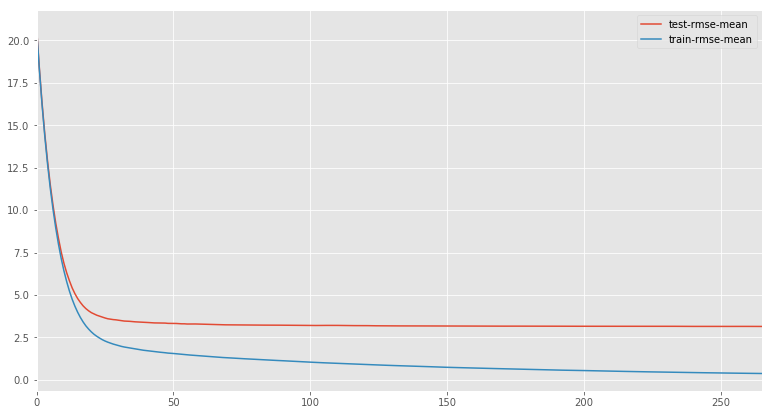

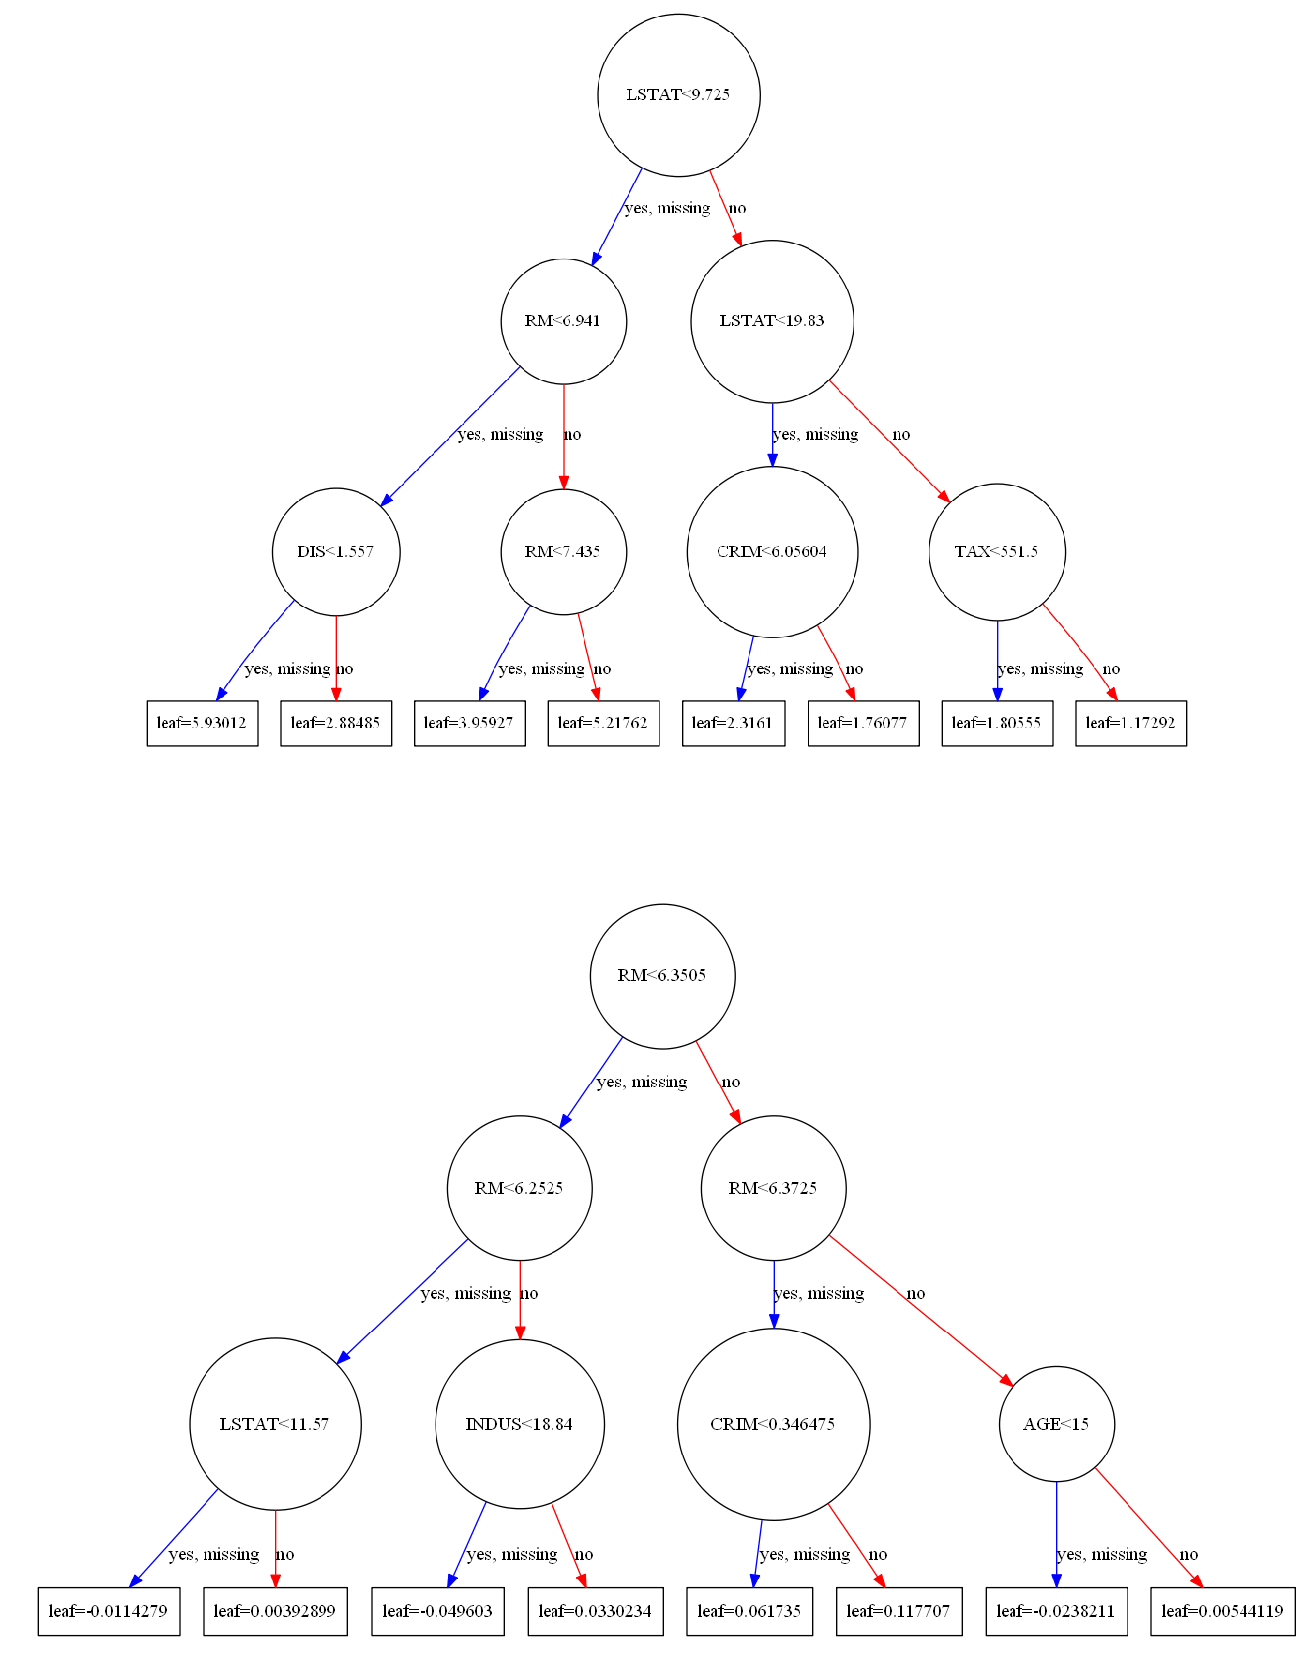

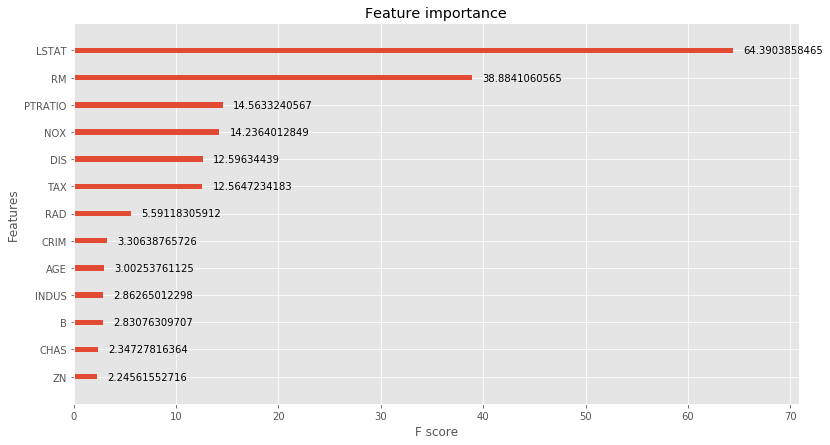

In [128]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005
}, dmat=DData)

    8. final result

In [218]:
param={
    'learning_rate':0.12,
    'n_estimators':266,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005
}
model=xgb.XGBRegressor(**param)
model.fit(dfTrain, dfTrainLabel)
predictions = model.predict(dfTest)
actuals = dfTestLabel
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.52415613368


### Compare to sklearn gbm

In [295]:
from sklearn.ensemble import GradientBoostingRegressor

In [355]:
gbm=GradientBoostingRegressor(n_estimators=266, 
                              max_depth=3, 
                              learning_rate=0.12, 
                              subsample=0.885,
                              random_state=1)
gbm.fit(dfTrain, dfTrainLabel)
predictions = gbm.predict(dfTest)
actuals = dfTestLabel
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.61421527576


### Partial Dependency

In [228]:
def plot_partial_dependency(model, X, y, col):
    X_temp = X.copy()

    x_grid = np.linspace(np.percentile(X_temp[col], 0.5), np.percentile(X_temp[col], 99.5), 100)
    y_partial = []

    for point in x_grid:
        X_temp[col] = point
        y_partial.append(np.average(model.predict(X_temp)))
    y_partial = np.array(y_partial)
    
    # Plot partial dependence
    plt.figure(figsize=(7,7))
    plt.plot(x_grid, y_partial, '-', color = 'black')
    plt.plot(X[col], y, 'o', color = 'blue', alpha = 0.1)
    plt.xlim(min(x_grid), max(x_grid))
    plt.xlabel('Feature %s'%col)    
    plt.ylabel('Partial Dependence')    
    plt.show()

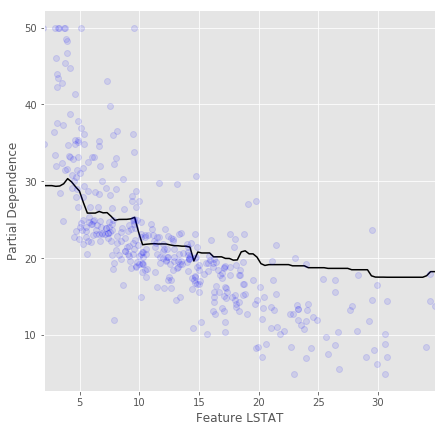

In [229]:
plot_partial_dependency(model, dfTrain, dfTrainLabel, 'LSTAT')

### base_score

In [177]:
dfTrainLabel.mean()

22.169306930693082

(241, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0          8.100261       1.115407         8.072480        0.285616
1          7.451679       0.961281         7.317700        0.261686
2          6.832327       0.860166         6.653178        0.226085
3          6.317365       0.764033         6.070968        0.200711
4          5.875471       0.661134         5.560923        0.166335
236        3.190707       0.433381         0.447641        0.021509
237        3.190143       0.432831         0.444453        0.021975
238        3.189512       0.433394         0.441988        0.022478
239        3.189520       0.433029         0.439897        0.022826
240        3.189126       0.432660         0.438288        0.022800

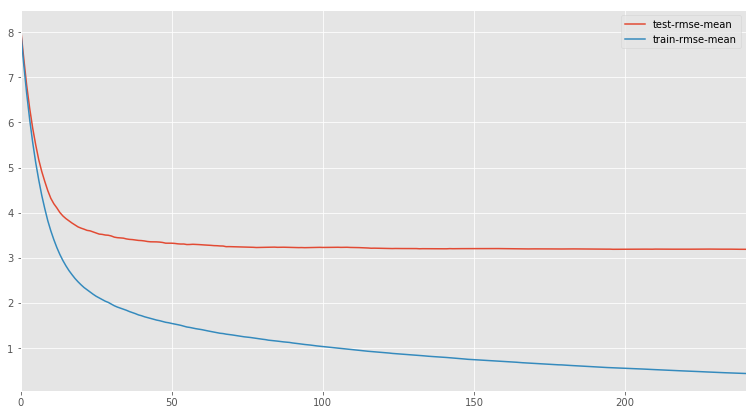

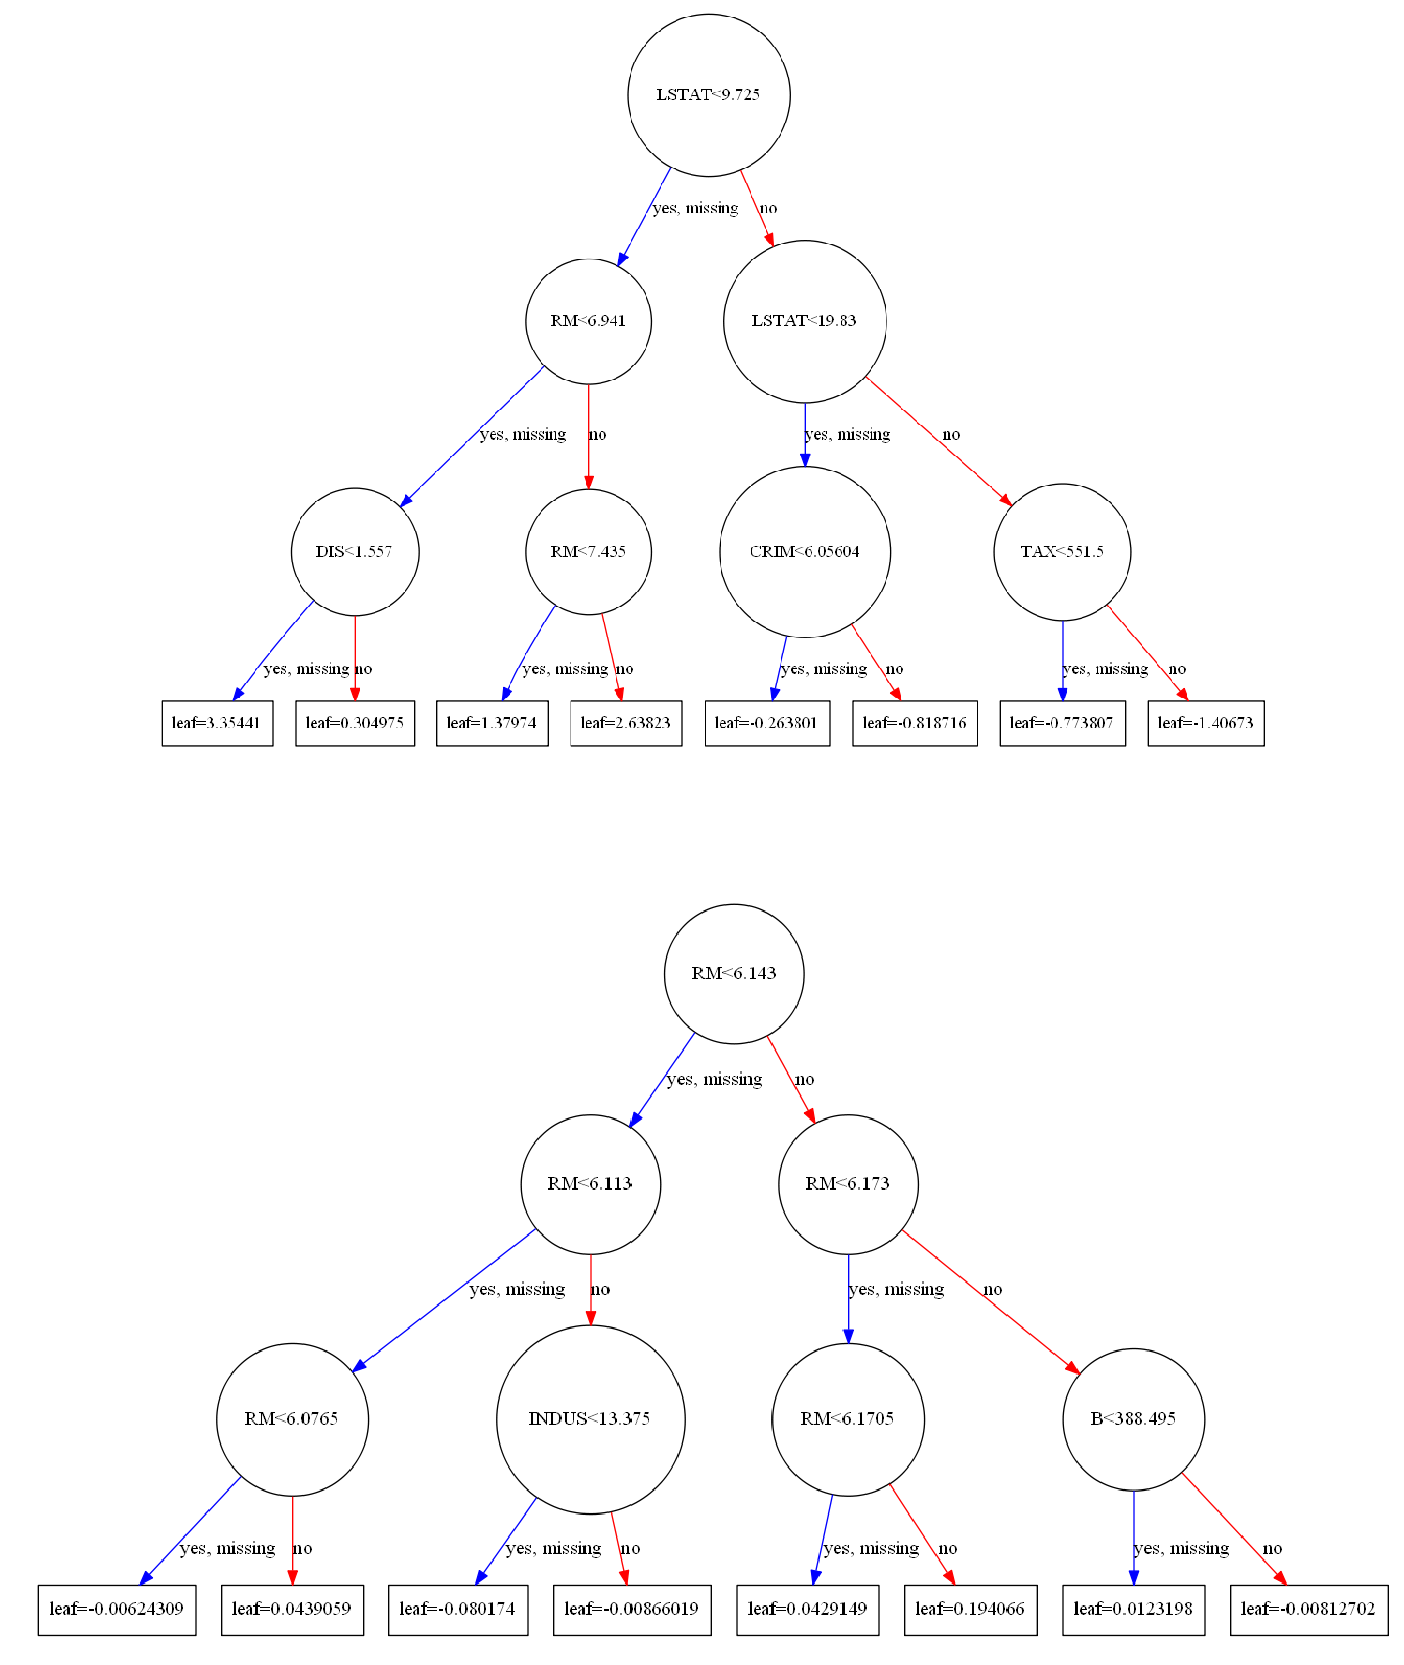

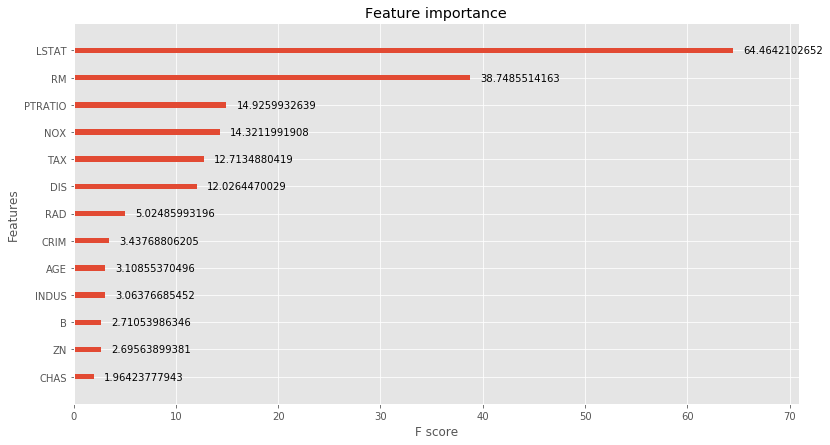

In [135]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'base_score':22
}, dmat=DData)

In [178]:
param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'base_score':22
}
model=xgb.XGBRegressor(**param)
model.fit(dfTrain, dfTrainLabel)
predictions = model.predict(dfTest)
actuals = dfTestLabel
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.552145787


    add bias

In [203]:
dfTrainLabel2=dfTrainLabel.copy()
dfTrainLabel2+=10000
dfTestLabel2=dfTestLabel.copy()
dfTestLabel2+=10000

In [195]:
DData2=xgb.DMatrix(dfTrain, label=dfTrainLabel2, feature_names=dfTrain.columns)

(149, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0       8819.117969       0.561887      8819.115820        0.114297
1       7760.854101       0.575476      7760.852149        0.104371
2       6829.584277       0.574505      6829.581934        0.103301
3       6010.038965       0.575339      6010.036816        0.103194
4       5288.858691       0.568530      5288.856641        0.111363
144        3.248212       0.332781         0.986516        0.035841
145        3.247957       0.331786         0.980481        0.032932
146        3.248205       0.331177         0.972670        0.032275
147        3.245304       0.330886         0.963536        0.030633
148        3.243096       0.330764         0.953480        0.030738

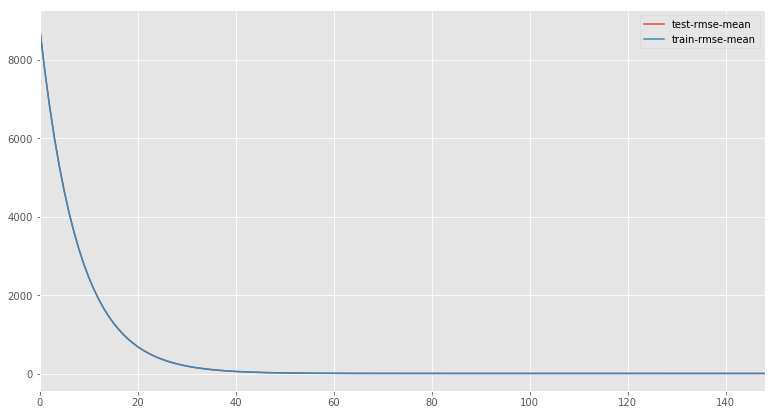

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=149,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.005, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.885)


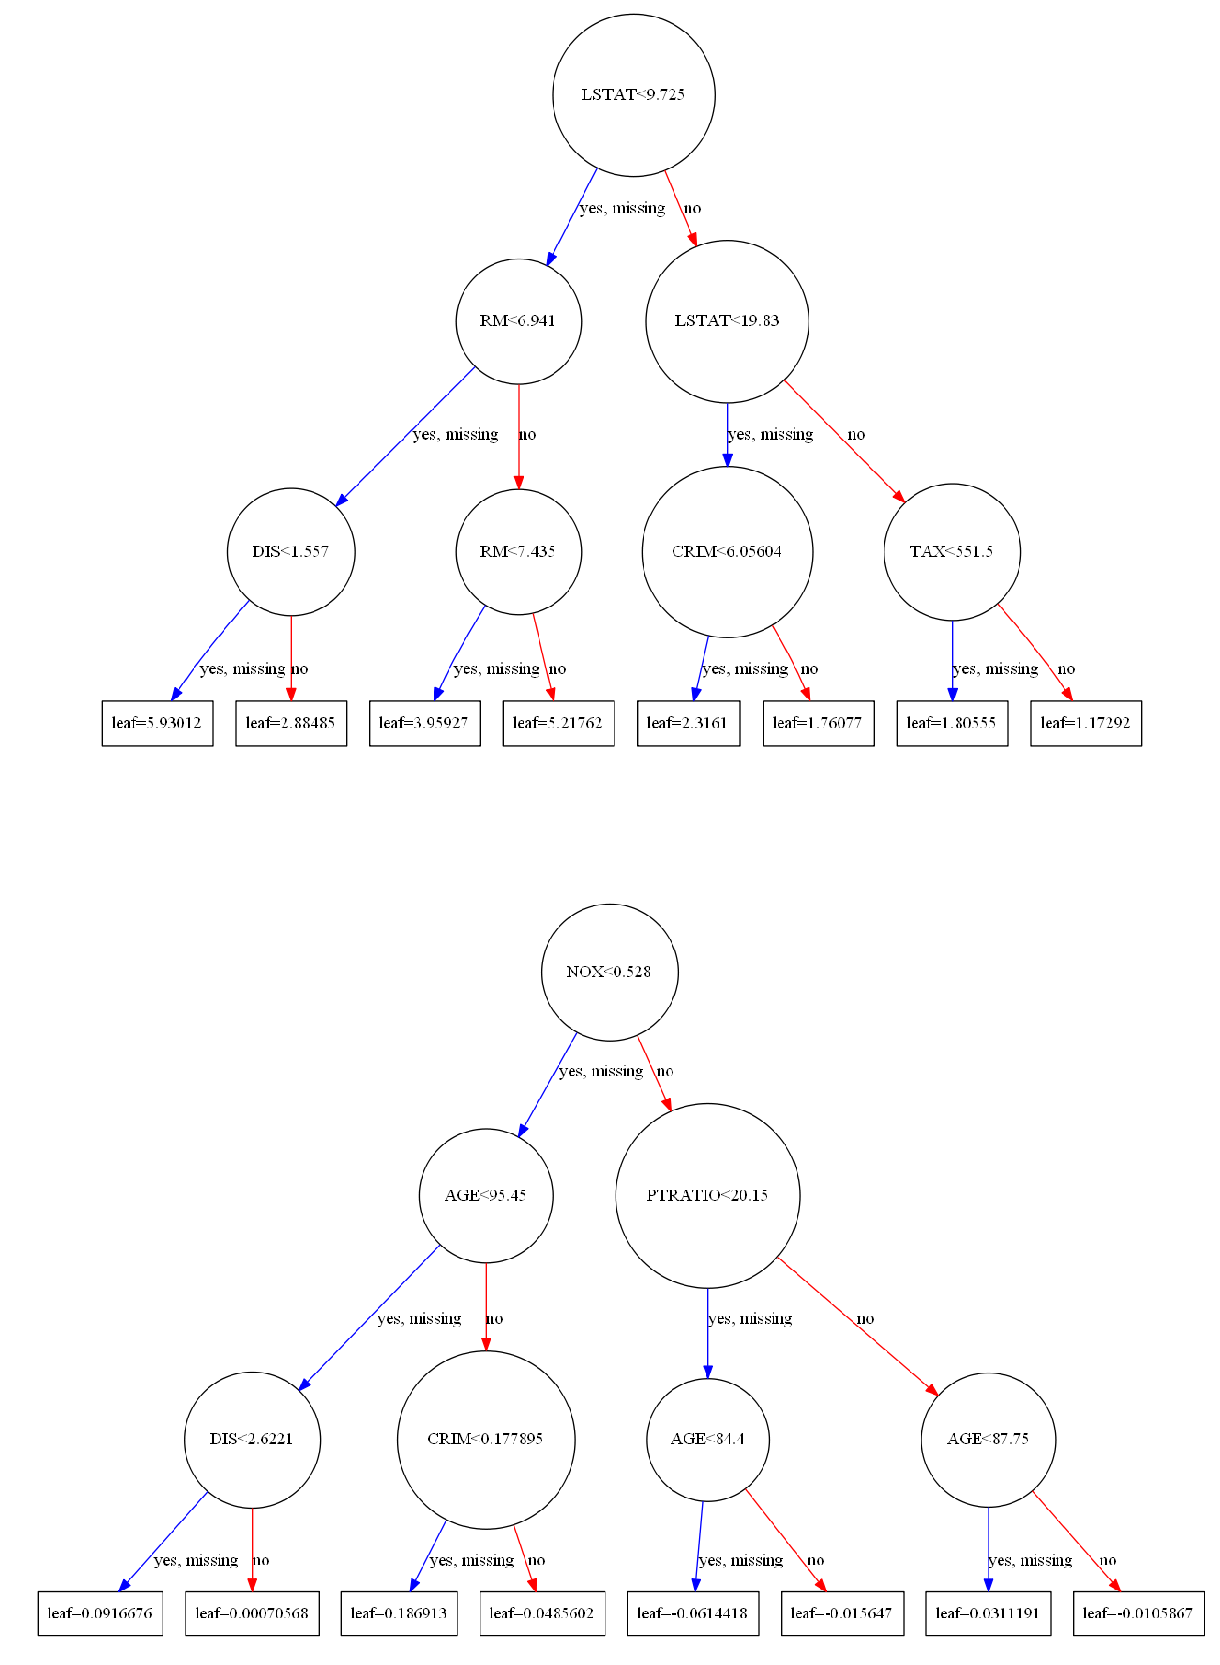

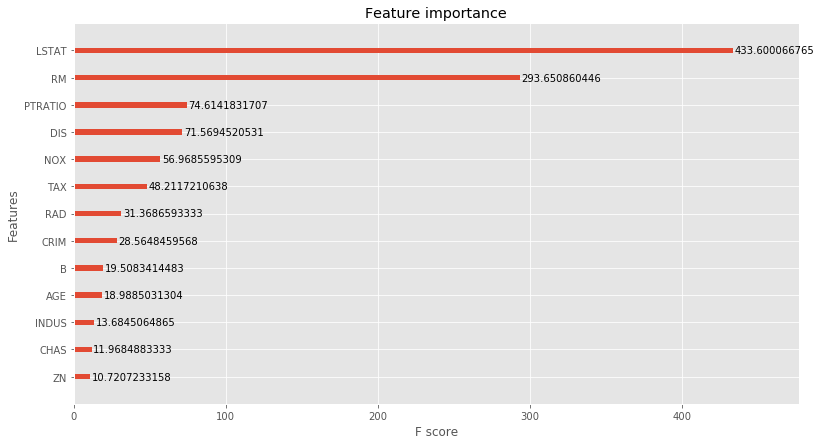

In [182]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
}, dmat=DData2)

(293, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         21.150111       0.871153        21.123763        0.205514
1         18.756162       0.773725        18.674588        0.186428
2         16.626687       0.689348        16.520292        0.169158
3         14.755505       0.615889        14.625132        0.163231
4         13.136121       0.552492        12.963922        0.142614
288        3.181176       0.447183         0.327782        0.017592
289        3.181410       0.447105         0.325764        0.018077
290        3.181530       0.447567         0.324368        0.017855
291        3.180928       0.447537         0.323122        0.017783
292        3.180366       0.447736         0.321494        0.017622

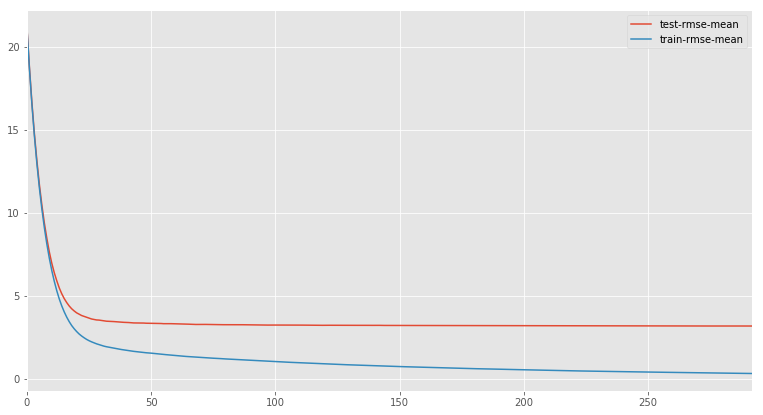

XGBRegressor(base_score=10000, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=293,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.005, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.885)


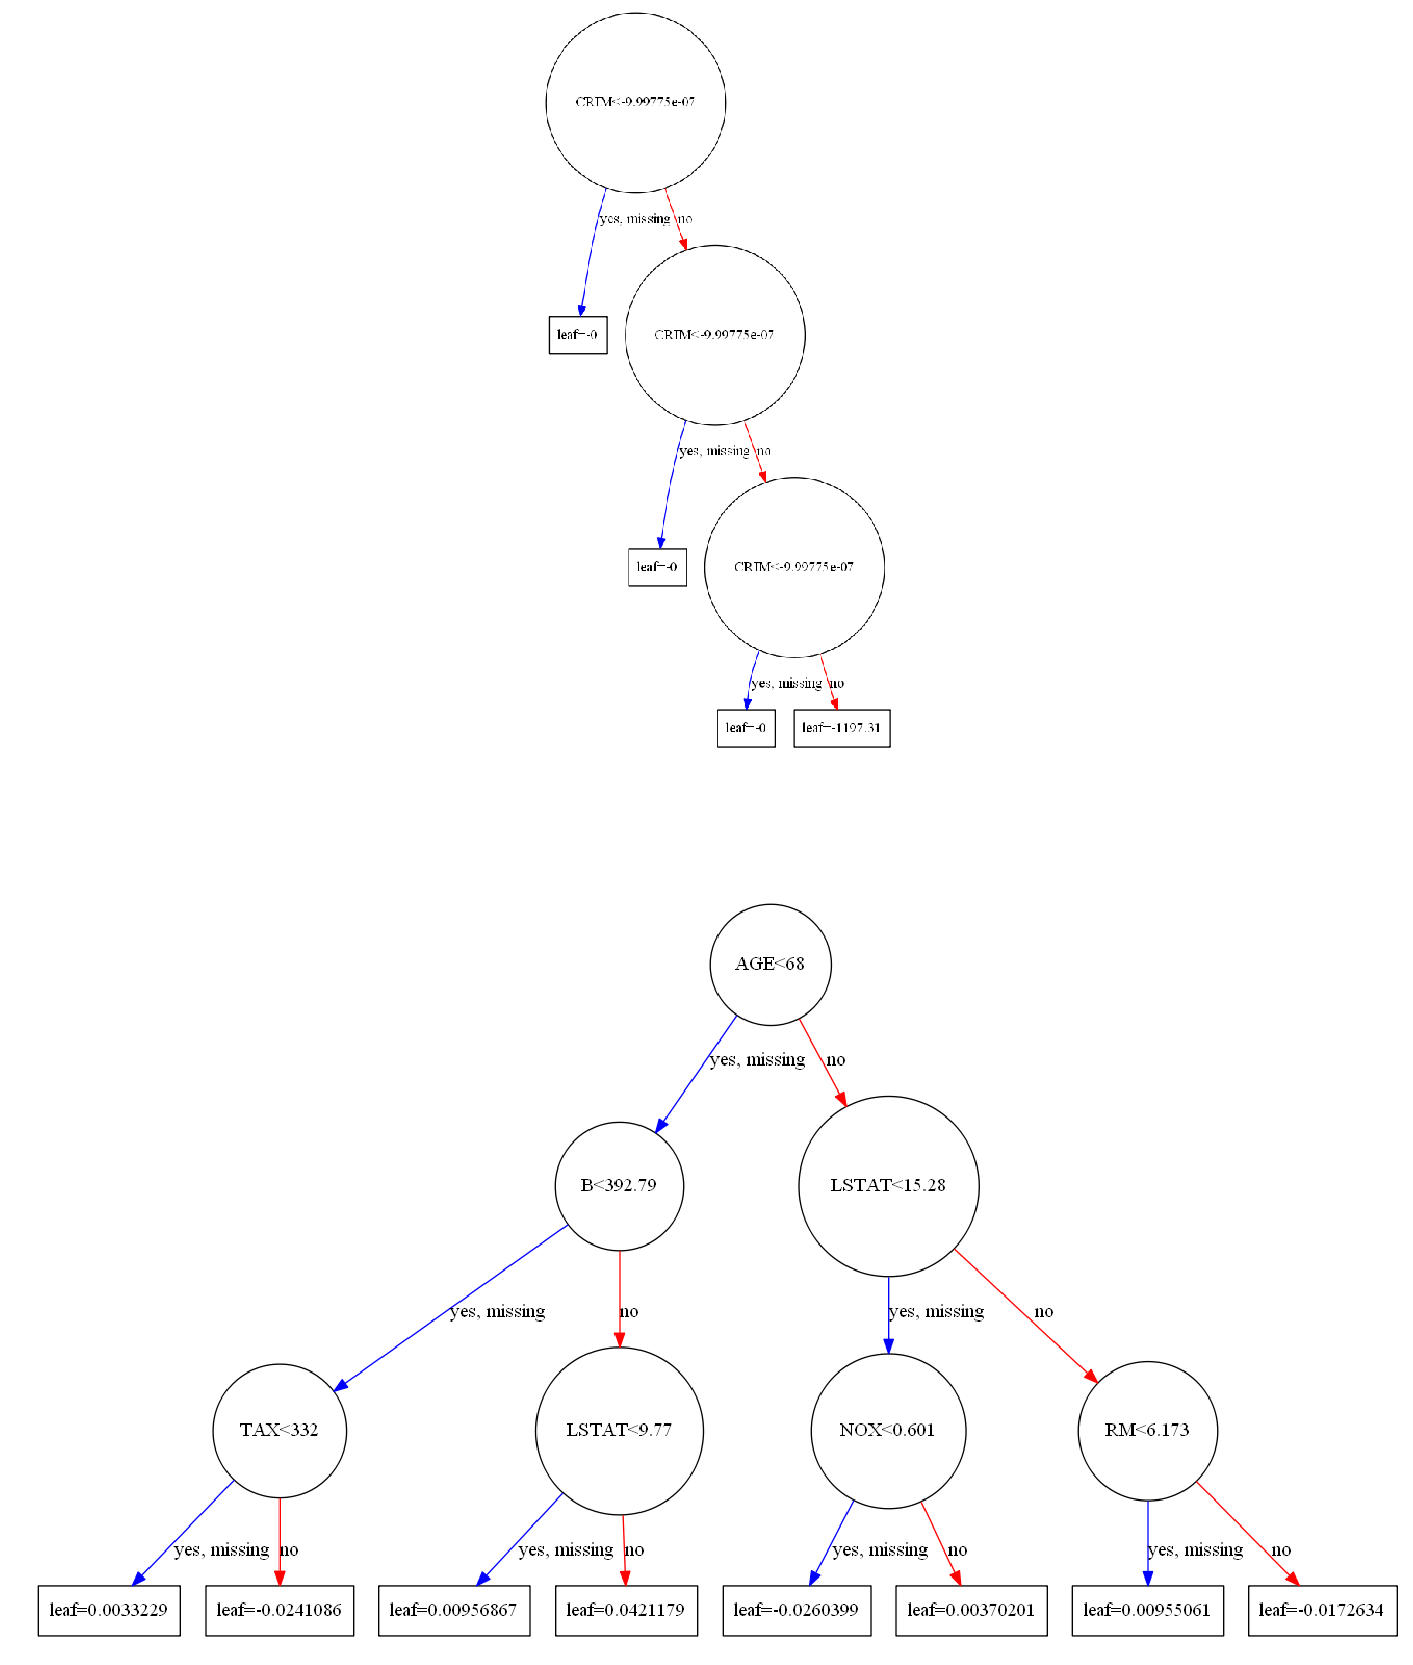

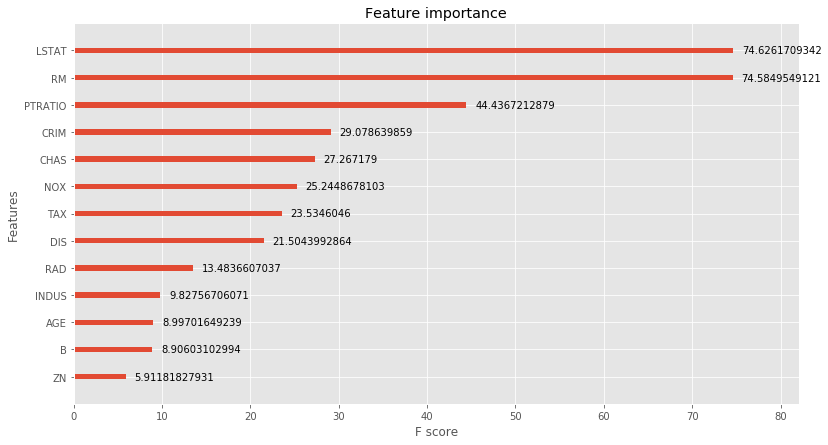

In [183]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'base_score':10000
}, dmat=DData2)

    tune reg_lambda without base_score

In [199]:
param={
    'learning_rate':0.12,
    'n_estimators':156,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
}
param_test = {
 'reg_lambda':np.linspace(0.05,0.1,20)
}
gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**param), 
                       param_grid=param_test, 
                       n_jobs=1, cv=5, verbose=1, scoring=scorer)
gsearch.fit(dfTrain,dfTrainLabel2)
print gsearch.best_params_
print gsearch.best_score_
display(DataFrame(gsearch.cv_results_).sort_values(by='mean_test_score', ascending=False).head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'reg_lambda': 0.057894736842105263}
-3.35982524947


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
3         0.0480           0.0010        -3.359825         -0.967512   
4         0.0498           0.0016        -3.363118         -0.976388   
1         0.0476           0.0012        -3.441460         -0.997373   
2         0.0492           0.0012        -3.454298         -0.966395   
9         0.0484           0.0012        -3.462265         -0.971732   

  param_reg_lambda                            params  rank_test_score  \
3        0.0578947  {u'reg_lambda': 0.0578947368421}                1   
4        0.0605263  {u'reg_lambda': 0.0605263157895}                2   
1        0.0526316  {u'reg_lambda': 0.0526315789474}                3   
2        0.0552632  {u'reg_lambda': 0.0552631578947}                4   
9        0.0736842  {u'reg_lambda': 0.0736842105263}                5   

   split0_test_score  split0_train_score  split1_test_score  \
3          -5.791281           -0.985813          -2.635474   
4          -5.737820           -1.001052          -2.741475   
1          -5.937791           -0.992954          -2.711057   
2          -5.952210           -0.966549          -2.743456   
9          -5.661240           -0.956951          -2.687274   

   split1_train_score  split2_test_score  split2_train_score  \
3           -1.013031          -2.838460           -0.960225   
4           -1.010739          -2.802480           -0.992184   
1           -1.009583          -2.798306           -0.984270   
2           -0.982736          -2.796966           -0.953262   
9           -1.018469          -3.271916           -1.001615   

   split3_test_score  split3_train_score  split4_test_score  \
3          -2.921372           -0.934612          -2.603198   
4          -2.926648           -0.934947          -2.597719   
1          -3.119836           -0.991036          -2.630298   
2          -3.145756           -0.968980          -2.622836   
9          -2.972663           -0.919170          -2.708934   

   split4_train_score  std_fit_time  std_score_time  std_test_score  \
3           -0.943879      0.001673        0.000632        1.223489   
4           -0.943019      0.002926        0.000490        1.193874   
1           -1.009023      0.001625        0.000400        1.261090   
2           -0.960447      0.000980        0.000400        1.262904   
9           -0.962457      0.002577        0.000400        1.121434   

   std_train_score  
3         0.028639  
4         0.031205  
1         0.010161  
2         0.009814  
9         0.035056

(156, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0       8819.340039       0.561653      8819.338086        0.114393
1       7761.247656       0.573056      7761.245605        0.106404
2       6830.105176       0.570405      6830.103125        0.107376
3       6010.650684       0.573247      6010.648633        0.105699
4       5289.530664       0.564359      5289.528613        0.115491
151        3.280572       0.350429         1.013538        0.037081
152        3.278208       0.351029         1.005520        0.036347
153        3.276733       0.351662         0.999733        0.037448
154        3.274629       0.350325         0.993066        0.039882
155        3.271896       0.351708         0.984921        0.039543

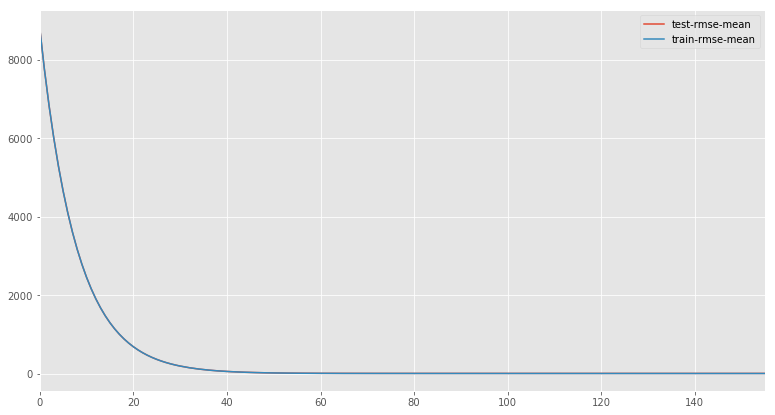

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=156,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.058, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.885)


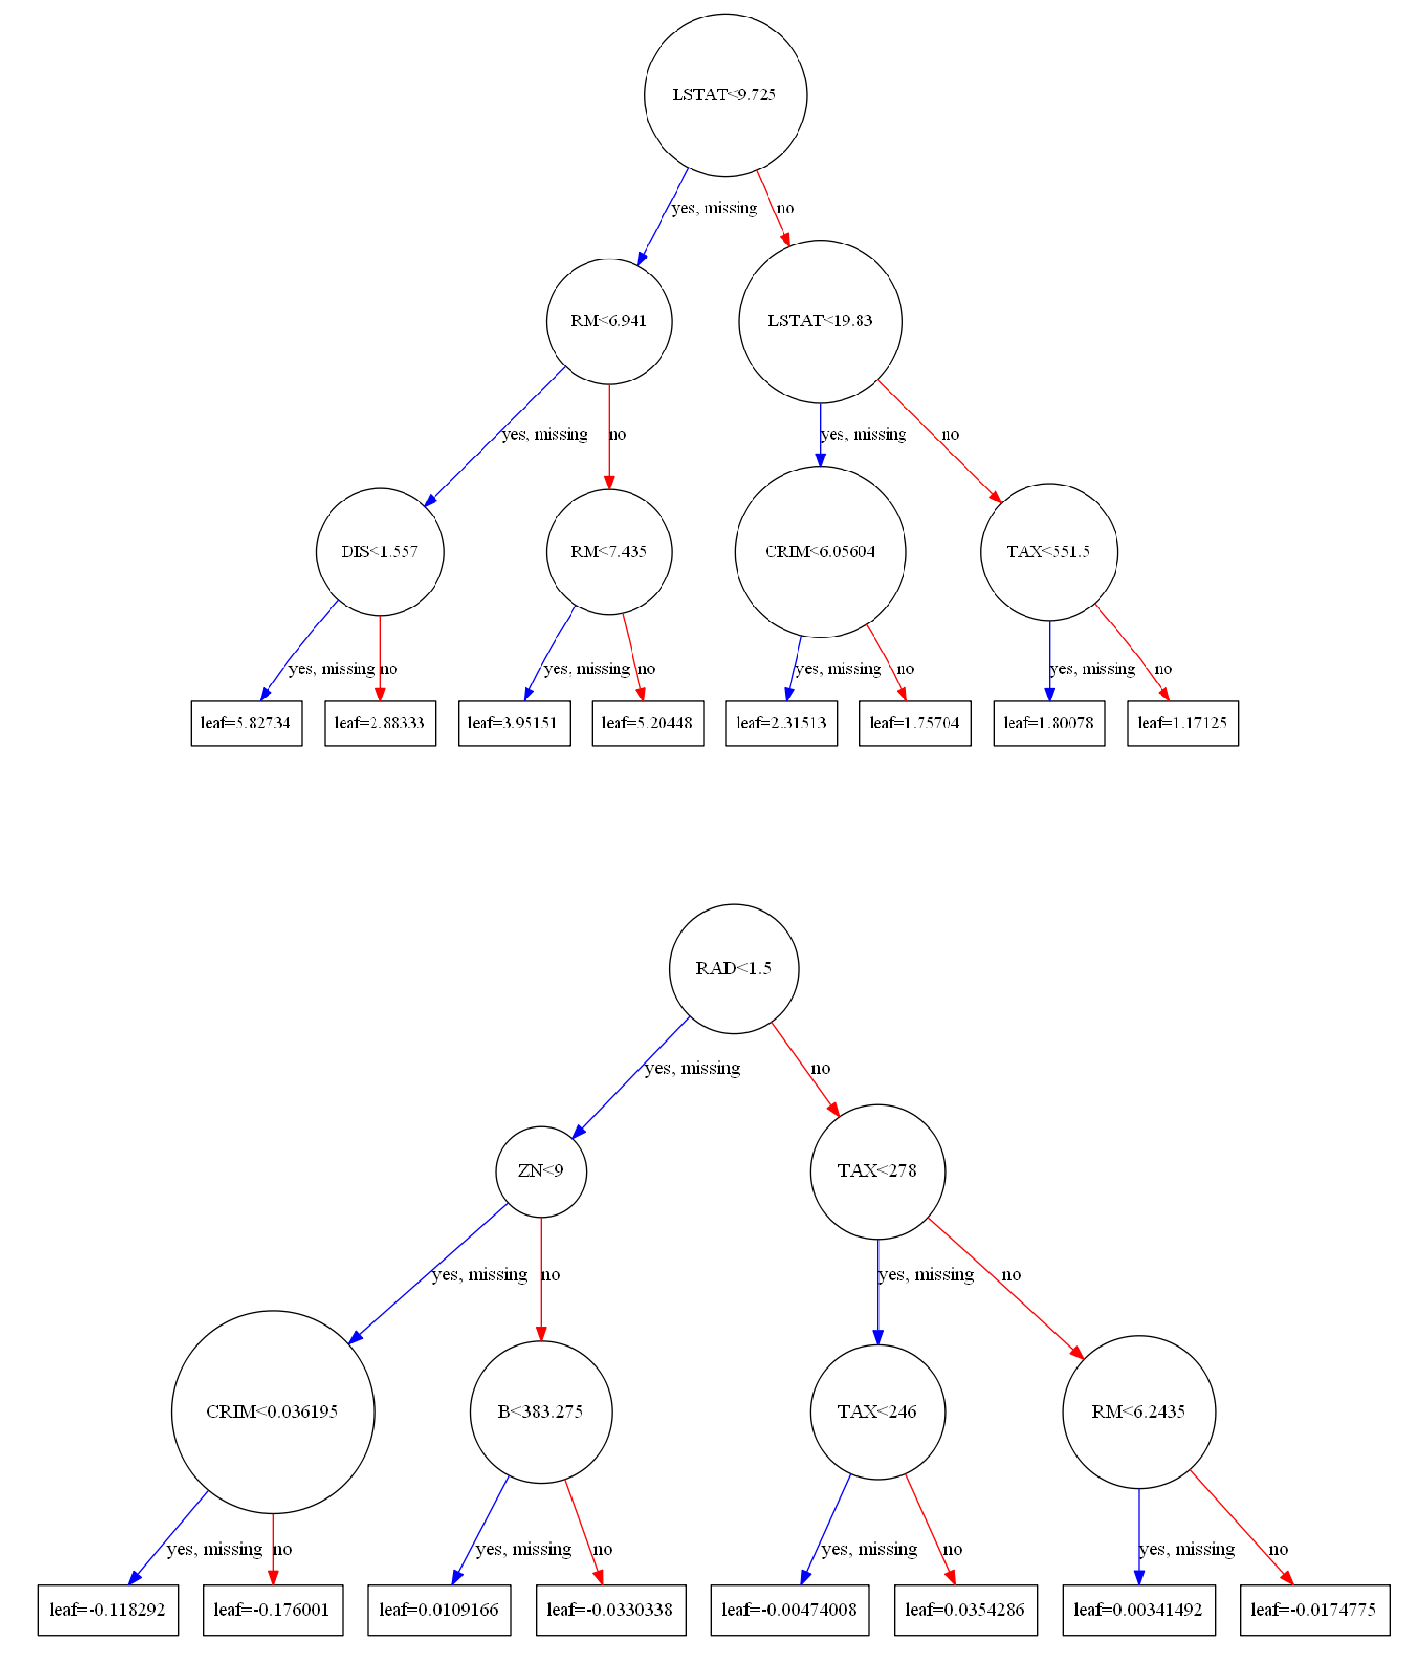

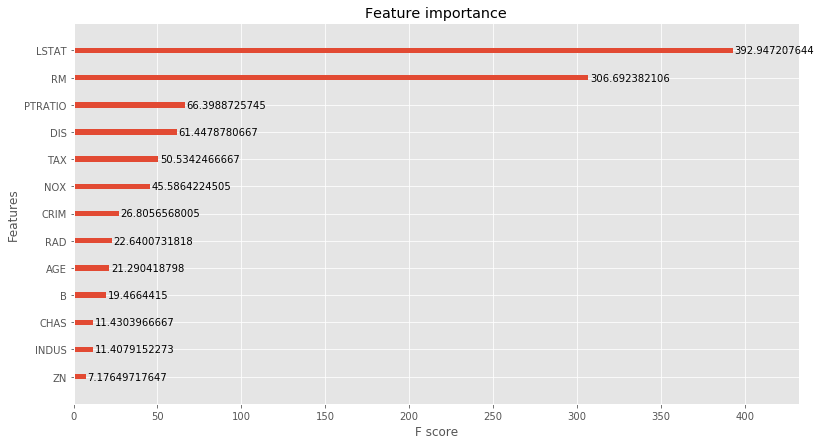

In [198]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.058
}, dmat=DData2)

In [205]:
param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.058,
}
model=xgb.XGBRegressor(**param)
model.fit(dfTrain, dfTrainLabel2)
predictions = model.predict(dfTest)
actuals = dfTestLabel2
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.86880882835


    tune reg_lambda with base_score

In [213]:
param={
    'learning_rate':0.12,
    'n_estimators':250,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'base_score':10000
}
param_test = {
 'reg_lambda':np.linspace(0.25,0.35,20)
}
gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**param), 
                       param_grid=param_test, 
                       n_jobs=1, cv=5, verbose=1, scoring=scorer)
gsearch.fit(dfTrain,dfTrainLabel2)
print gsearch.best_params_
print gsearch.best_score_
display(DataFrame(gsearch.cv_results_).sort_values(by='mean_test_score', ascending=False).head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'reg_lambda': 0.26578947368421052}
-3.31210469357


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.4s finished


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
3          0.0822           0.0018        -3.312105         -0.455278   
16         0.0826           0.0014        -3.316414         -0.456707   
0          0.0850           0.0016        -3.329135         -0.445855   
7          0.0752           0.0016        -3.329818         -0.437521   
1          0.0760           0.0014        -3.334305         -0.446151   

   param_reg_lambda                           params  rank_test_score  \
3          0.265789  {u'reg_lambda': 0.265789473684}                1   
16         0.334211  {u'reg_lambda': 0.334210526316}                2   
0              0.25            {u'reg_lambda': 0.25}                3   
7          0.286842  {u'reg_lambda': 0.286842105263}                4   
1          0.255263  {u'reg_lambda': 0.255263157895}                5   

    split0_test_score  split0_train_score  split1_test_score  \
3           -5.740628           -0.449188          -2.510863   
16          -6.014918           -0.469357          -2.365754   
0           -5.809053           -0.437273          -2.624310   
7           -5.956755           -0.431291          -2.449296   
1           -5.731781           -0.426982          -2.458887   

    split1_train_score  split2_test_score  split2_train_score  \
3            -0.477885          -2.748097           -0.458973   
16           -0.466218          -2.707795           -0.431073   
0            -0.455849          -2.798342           -0.442020   
7            -0.468302          -2.732353           -0.417914   
1            -0.469776          -2.883437           -0.439136   

    split3_test_score  split3_train_score  split4_test_score  \
3           -3.115418           -0.434530          -2.434685   
16          -2.997741           -0.449282          -2.485603   
0           -2.994612           -0.424686          -2.407983   
7           -3.046673           -0.431079          -2.453193   
1           -3.161232           -0.425512          -2.424963   

    split4_train_score  std_fit_time  std_score_time  std_test_score  \
3            -0.455815      0.002040         0.00040        1.239017   
16           -0.467605      0.004964         0.00049        1.368393   
0            -0.469448      0.003899         0.00049        1.256818   
7            -0.439019      0.001166         0.00049        1.333731   
1            -0.469348      0.000894         0.00049        1.231495   

    std_train_score  
3          0.014089  
16         0.014707  
0          0.015446  
7          0.016819  
1          0.019692

(250, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         21.182079       0.888955        21.161569        0.203191
1         18.822221       0.839724        18.747209        0.177561
2         16.706863       0.741055        16.621846        0.153985
3         14.833573       0.683163        14.743229        0.151930
4         13.228779       0.607329        13.091176        0.133381
245        3.199395       0.400849         0.441737        0.028161
246        3.199468       0.400888         0.439701        0.028360
247        3.200152       0.400578         0.437110        0.028047
248        3.199757       0.401819         0.434899        0.027810
249        3.199018       0.401912         0.433291        0.027760

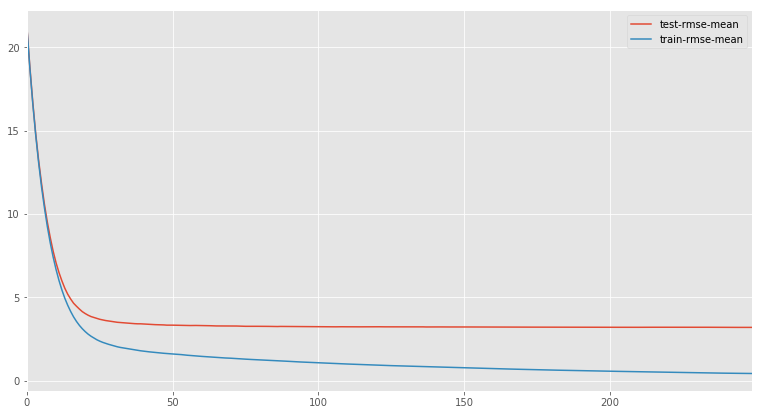

XGBRegressor(base_score=10000, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.3, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.885)


In [212]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.3,
    'base_score':10000
}, dmat=DData2)

In [214]:
param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.3,
    'base_score':10000
}
model=xgb.XGBRegressor(**param)
model.fit(dfTrain, dfTrainLabel2)
predictions = model.predict(dfTest)
actuals = dfTestLabel2
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.69806632054


### tree_methods

    exact

(266, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         20.744337       0.877421        20.717855        0.207138
1         18.401370       0.778964        18.318955        0.188018
2         16.316617       0.694062        16.209047        0.170544
3         14.485071       0.620085        14.352938        0.164413
4         12.900555       0.555975        12.726059        0.143593
261        3.151366       0.447301         0.386841        0.023396
262        3.150875       0.447770         0.384664        0.023283
263        3.150065       0.448617         0.382317        0.022715
264        3.149565       0.449366         0.380746        0.022624
265        3.149131       0.449726         0.378819        0.022747

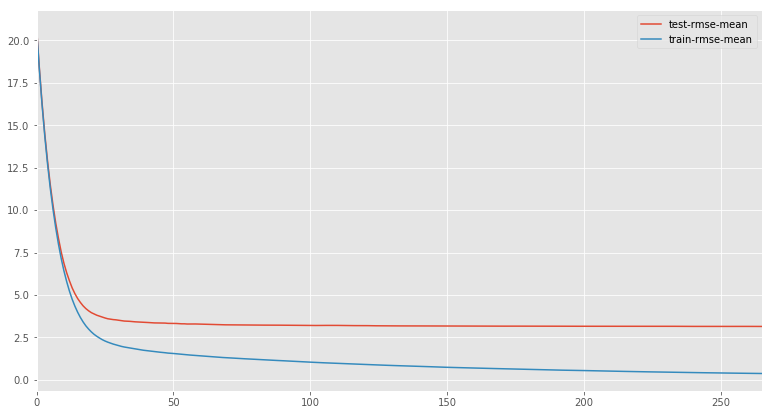

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=266,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.005, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.885, tree_method='exact')


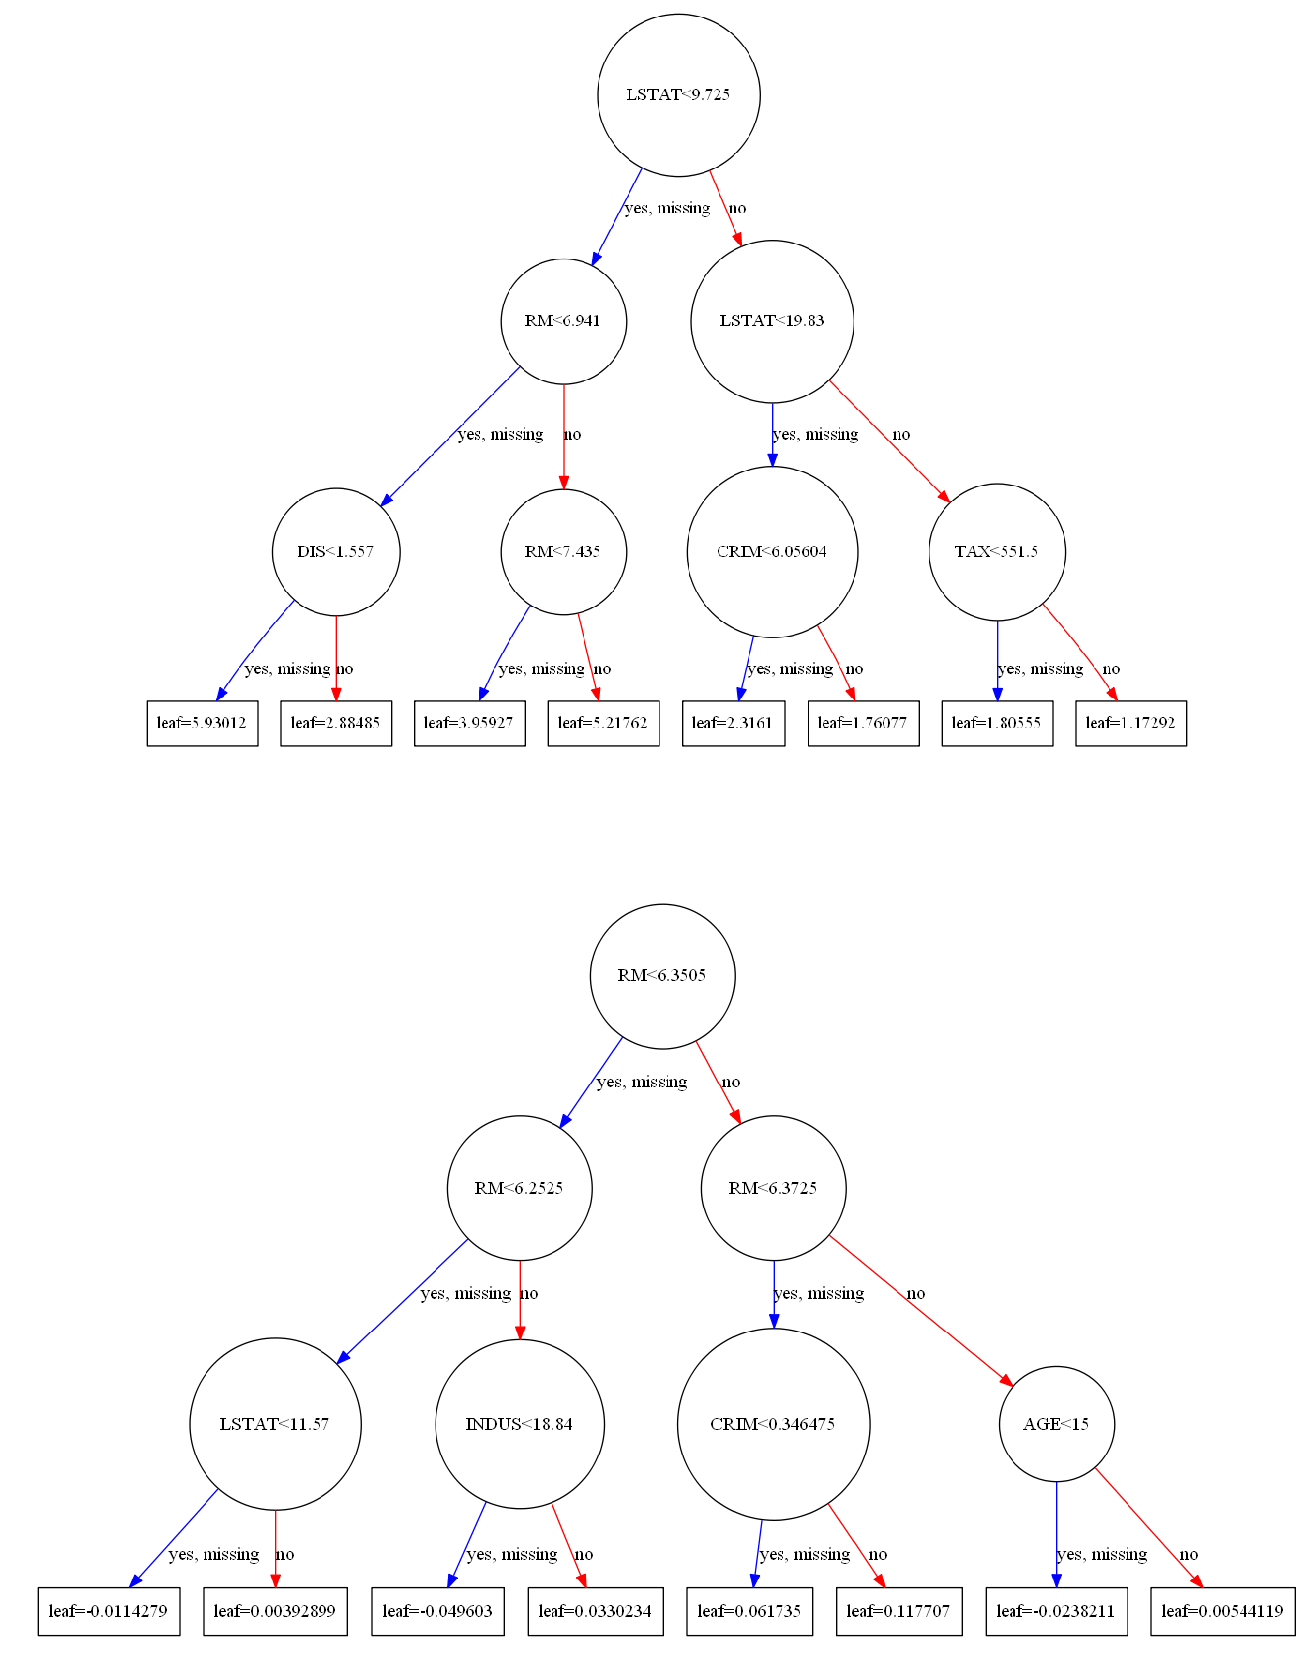

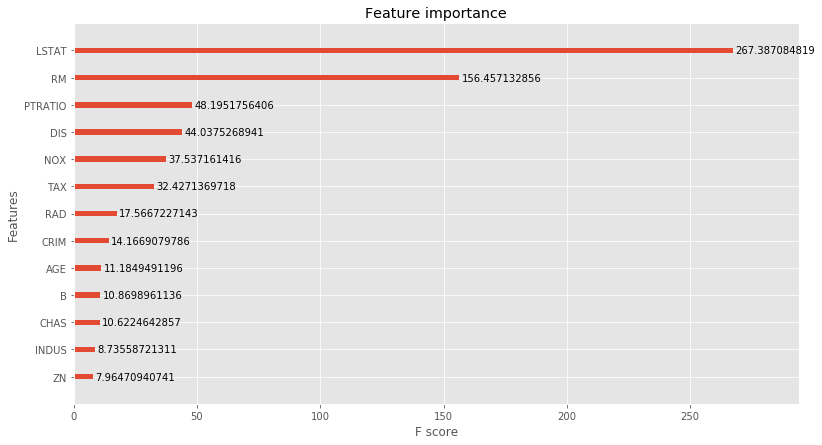

In [215]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'exact'
}, dmat=DData)

In [217]:
param={
    'learning_rate':0.12,
    'n_estimators':266,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'exact'
}
model=xgb.XGBRegressor(**param)
model.fit(dfTrain, dfTrainLabel)
predictions = model.predict(dfTest)
actuals = dfTestLabel
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.52415613368


    approx

(266, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         20.744337       0.877421        20.717855        0.207138
1         18.401370       0.778964        18.318955        0.188018
2         16.316617       0.694062        16.209047        0.170544
3         14.485071       0.620085        14.352938        0.164413
4         12.900555       0.555975        12.726059        0.143593
261        3.151366       0.447301         0.386841        0.023396
262        3.150875       0.447770         0.384664        0.023283
263        3.150065       0.448617         0.382317        0.022715
264        3.149565       0.449366         0.380746        0.022624
265        3.149131       0.449726         0.378819        0.022747

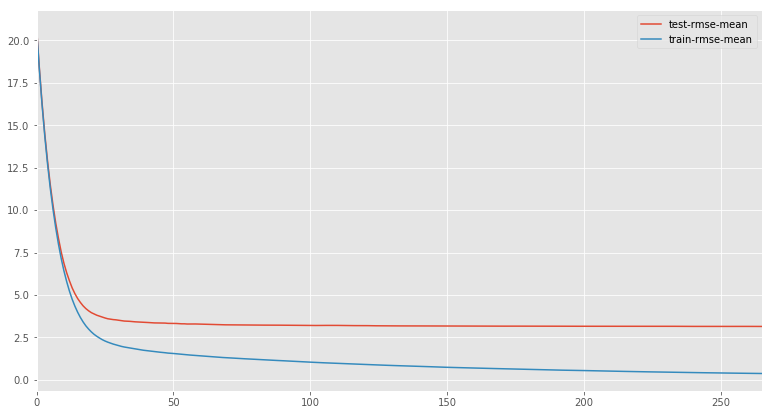

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=266,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.005, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.885, tree_method='approx')


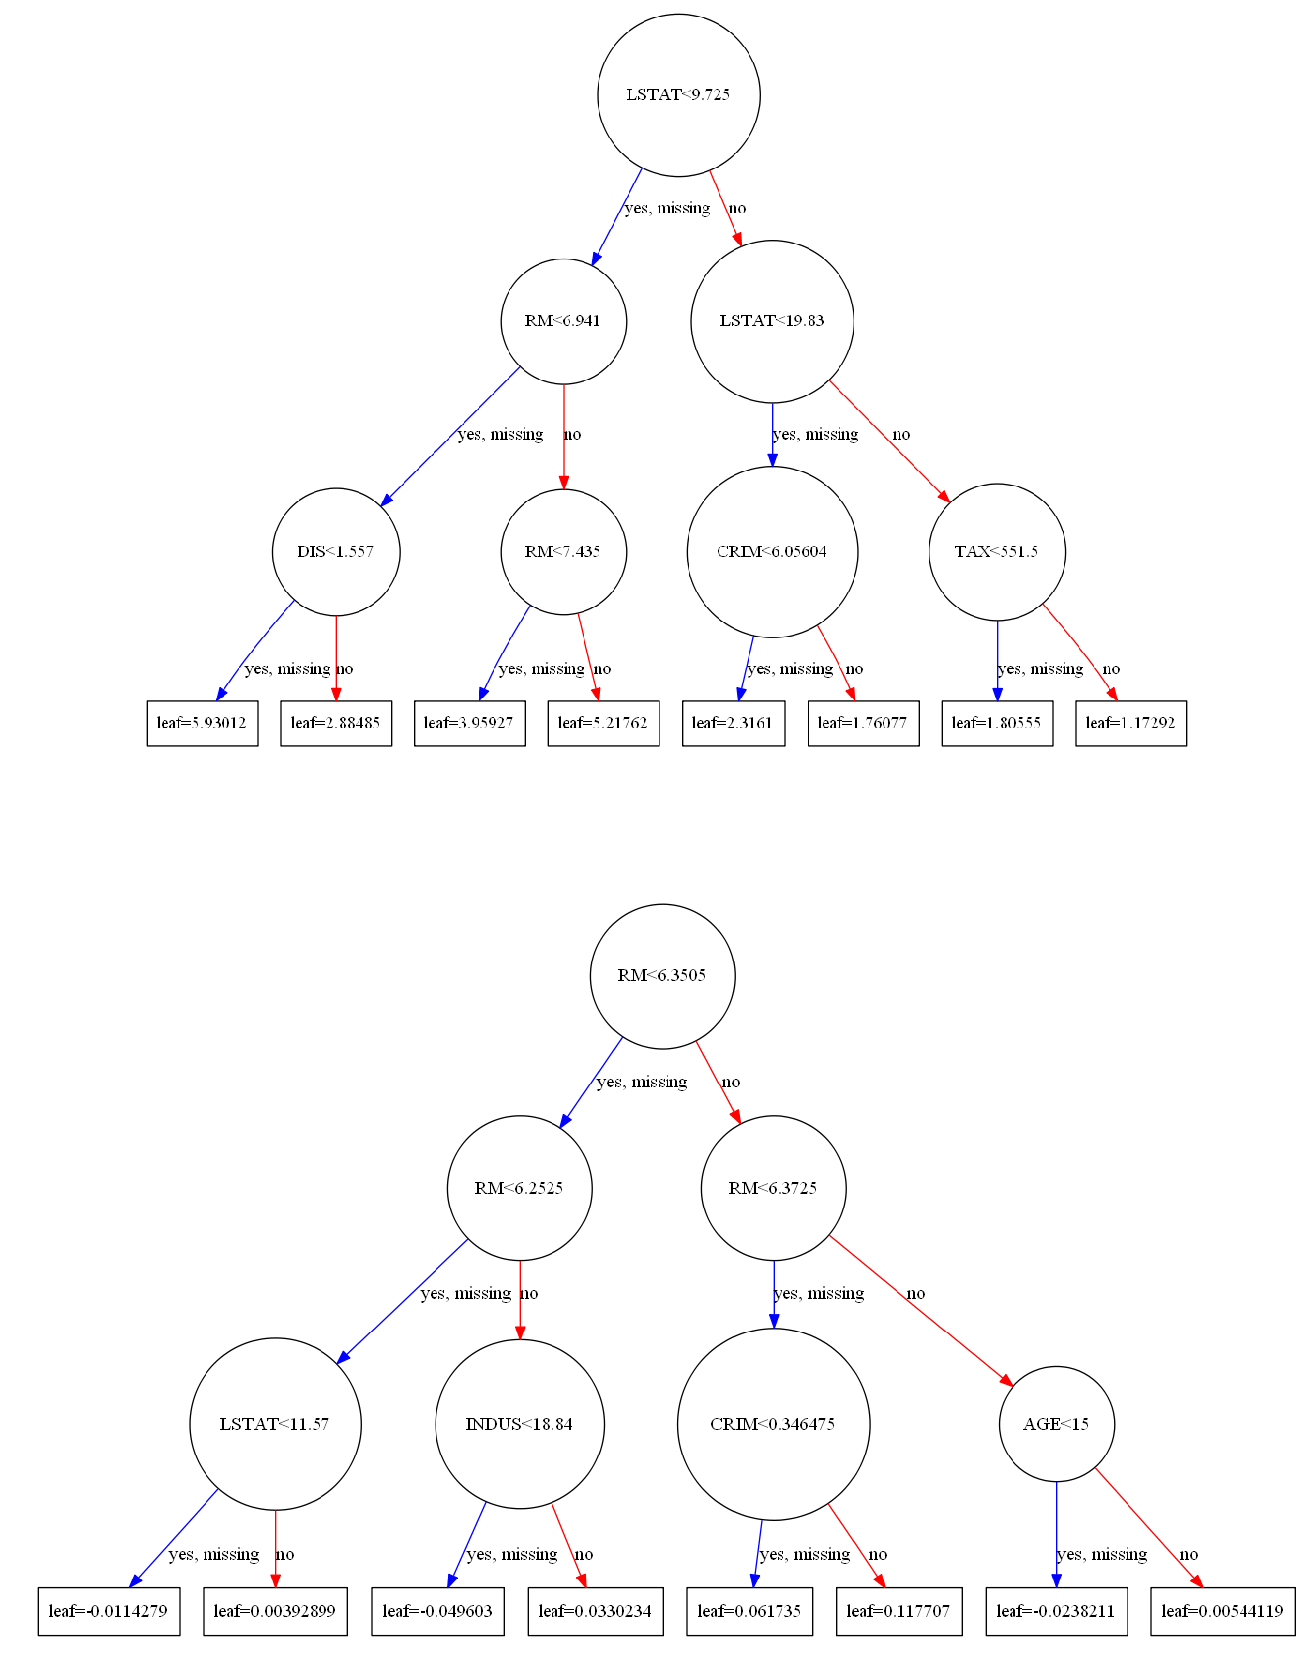

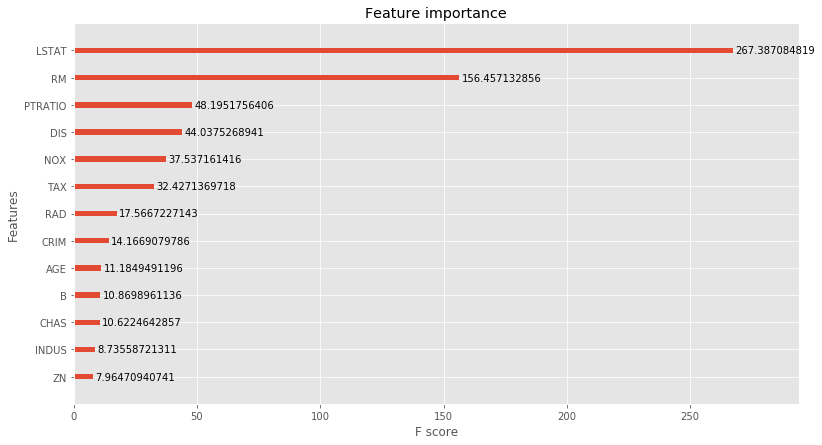

In [219]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'approx'
}, dmat=DData)

In [220]:
param={
    'learning_rate':0.12,
    'n_estimators':266,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'approx'
}
model=xgb.XGBRegressor(**param)
model.fit(dfTrain, dfTrainLabel)
predictions = model.predict(dfTest)
actuals = dfTestLabel
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.52415613368


    hist

(241, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         20.747701       0.877586        20.719337        0.207293
1         18.402407       0.760779        18.324780        0.187714
2         16.306207       0.663227        16.212171        0.170734
3         14.493513       0.604625        14.351055        0.161946
4         12.882967       0.537527        12.721149        0.139344
236        3.220940       0.480521         0.438109        0.017933
237        3.220575       0.478906         0.436156        0.017284
238        3.220239       0.479635         0.433374        0.017493
239        3.218990       0.479793         0.430638        0.017563
240        3.218403       0.479353         0.428341        0.017640

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=241,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.005, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.885, tree_method='hist')


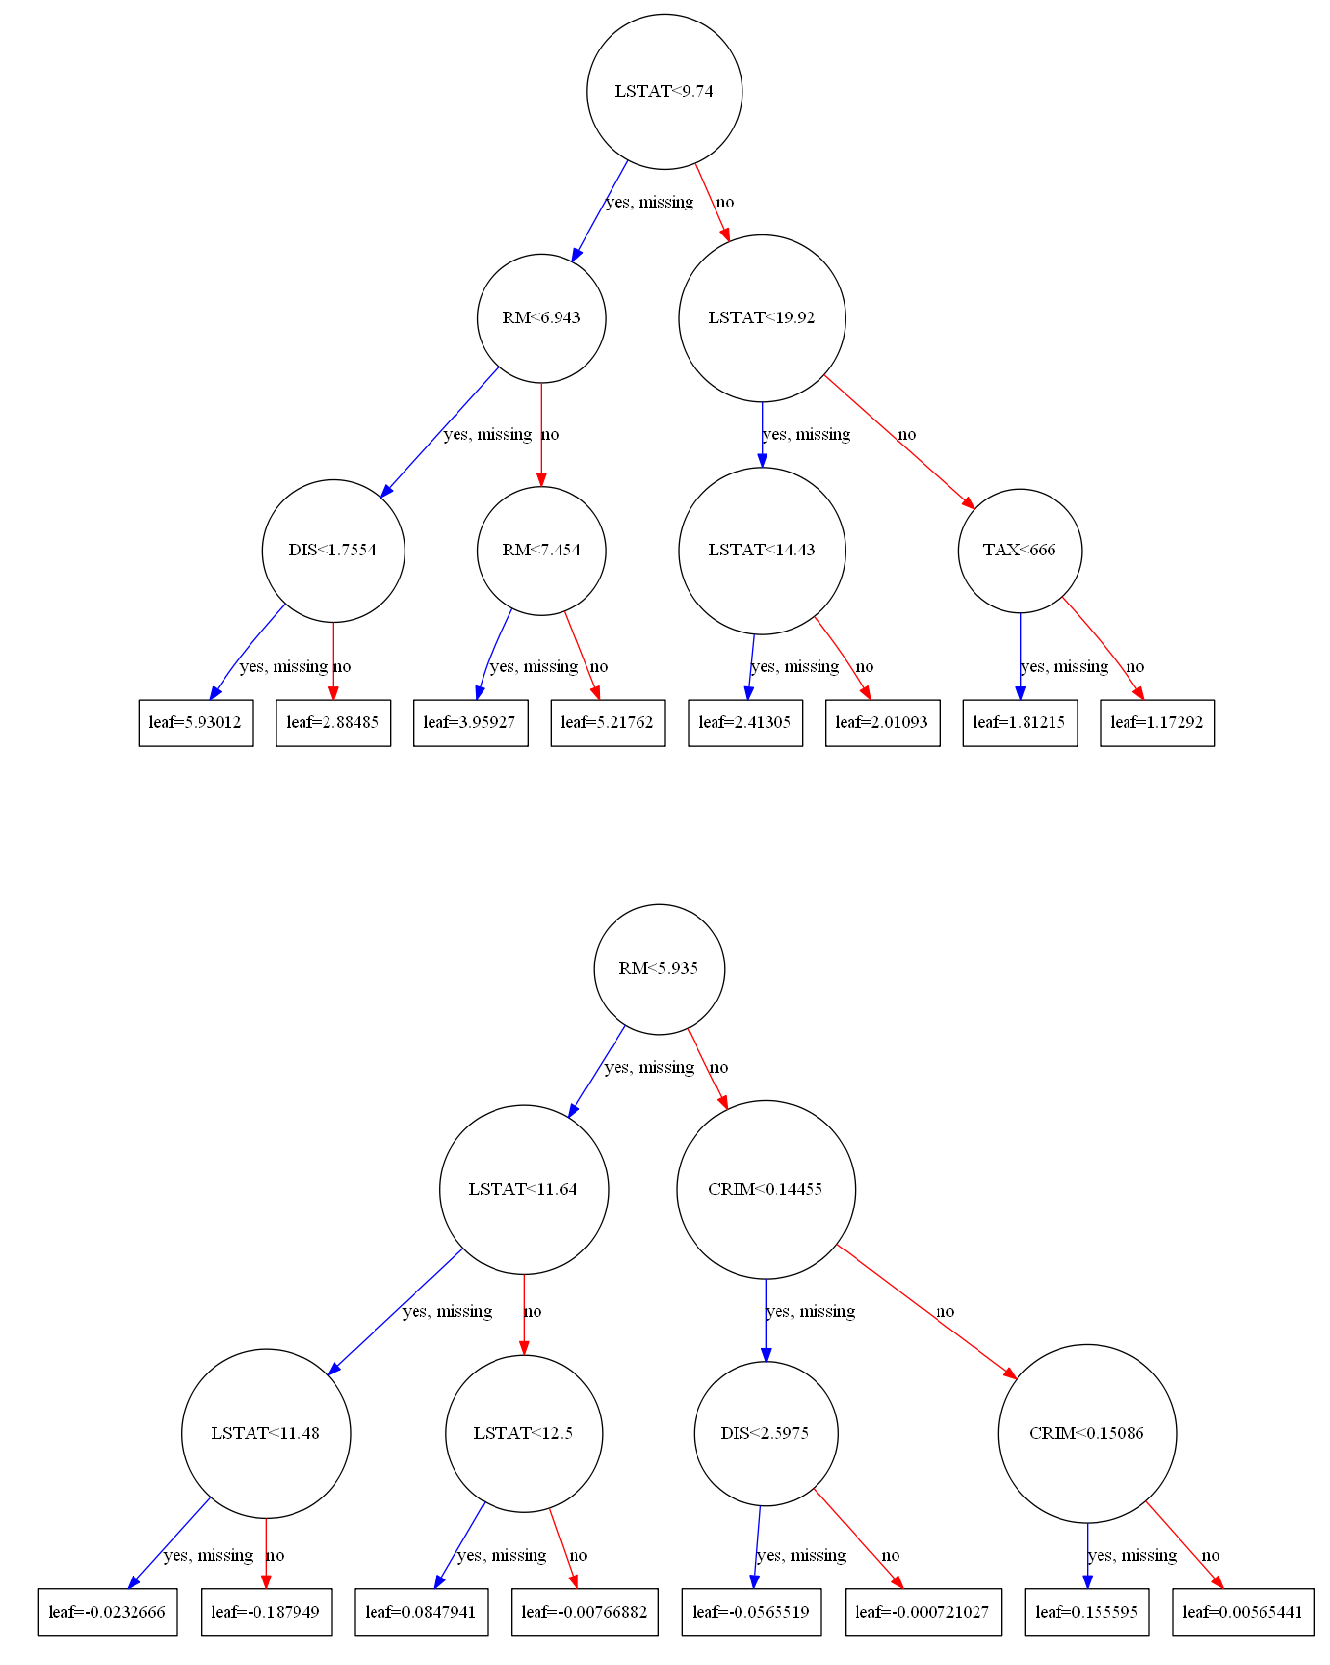

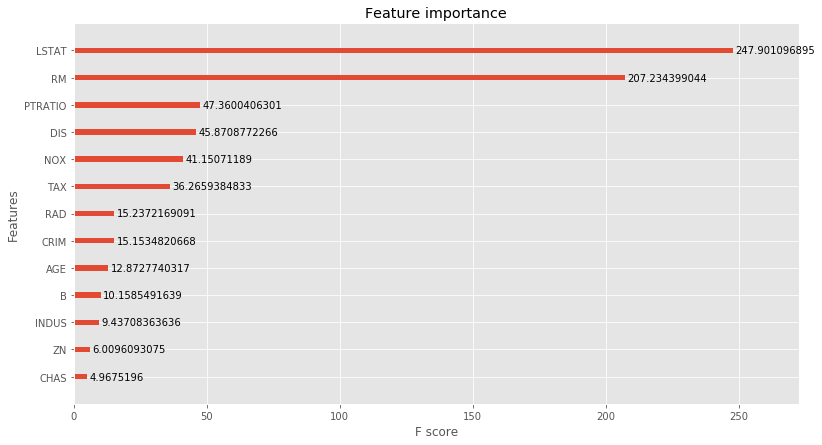

In [221]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'hist'
}, dmat=DData)

In [223]:
param={
    'learning_rate':0.12,
    'n_estimators':241,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'hist'
}
model=xgb.XGBRegressor(**param)
model.fit(dfTrain, dfTrainLabel)
predictions = model.predict(dfTest)
actuals = dfTestLabel
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.40254431285


### monotone constraint

In [235]:
mono_flag=[0 for i in range(dfTrain.shape[1])]
mono_flag[-1]=-1

In [240]:
mono_flag

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

In [238]:
param={
    'learning_rate':0.12,
    'n_estimators':266,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'exact',
    'monotone_constraints':tuple(mono_flag)
}
model=xgb.XGBRegressor(**param)
model.fit(dfTrain, dfTrainLabel)
predictions = model.predict(dfTest)
actuals = dfTestLabel
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.59436717126


In [239]:
plot_partial_dependency(model, dfTrain, dfTrainLabel, 'LSTAT')

### random forest

(266, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         20.744337       0.877421        20.717855        0.207138
1         18.401370       0.778964        18.318955        0.188018
2         16.316617       0.694062        16.209047        0.170544
3         14.485071       0.620085        14.352938        0.164413
4         12.900555       0.555975        12.726059        0.143593
261        3.151366       0.447301         0.386841        0.023396
262        3.150875       0.447770         0.384664        0.023283
263        3.150065       0.448617         0.382317        0.022715
264        3.149565       0.449366         0.380746        0.022624
265        3.149131       0.449726         0.378819        0.022747

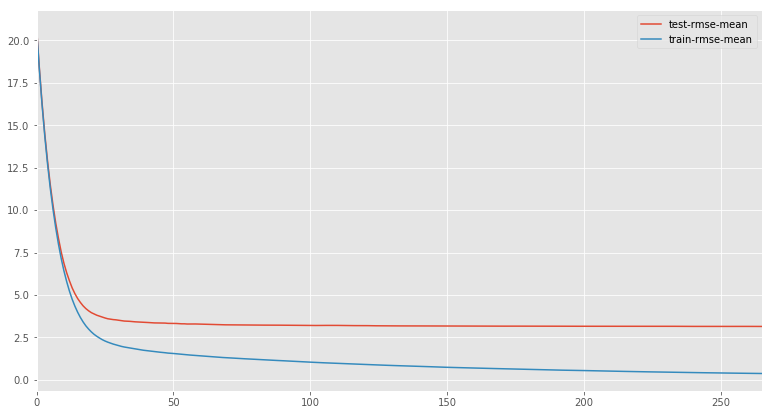

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=266,
       n_jobs=1, nthread=None, num_parallel_tree=1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=0.005, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.885, tree_method='exact')


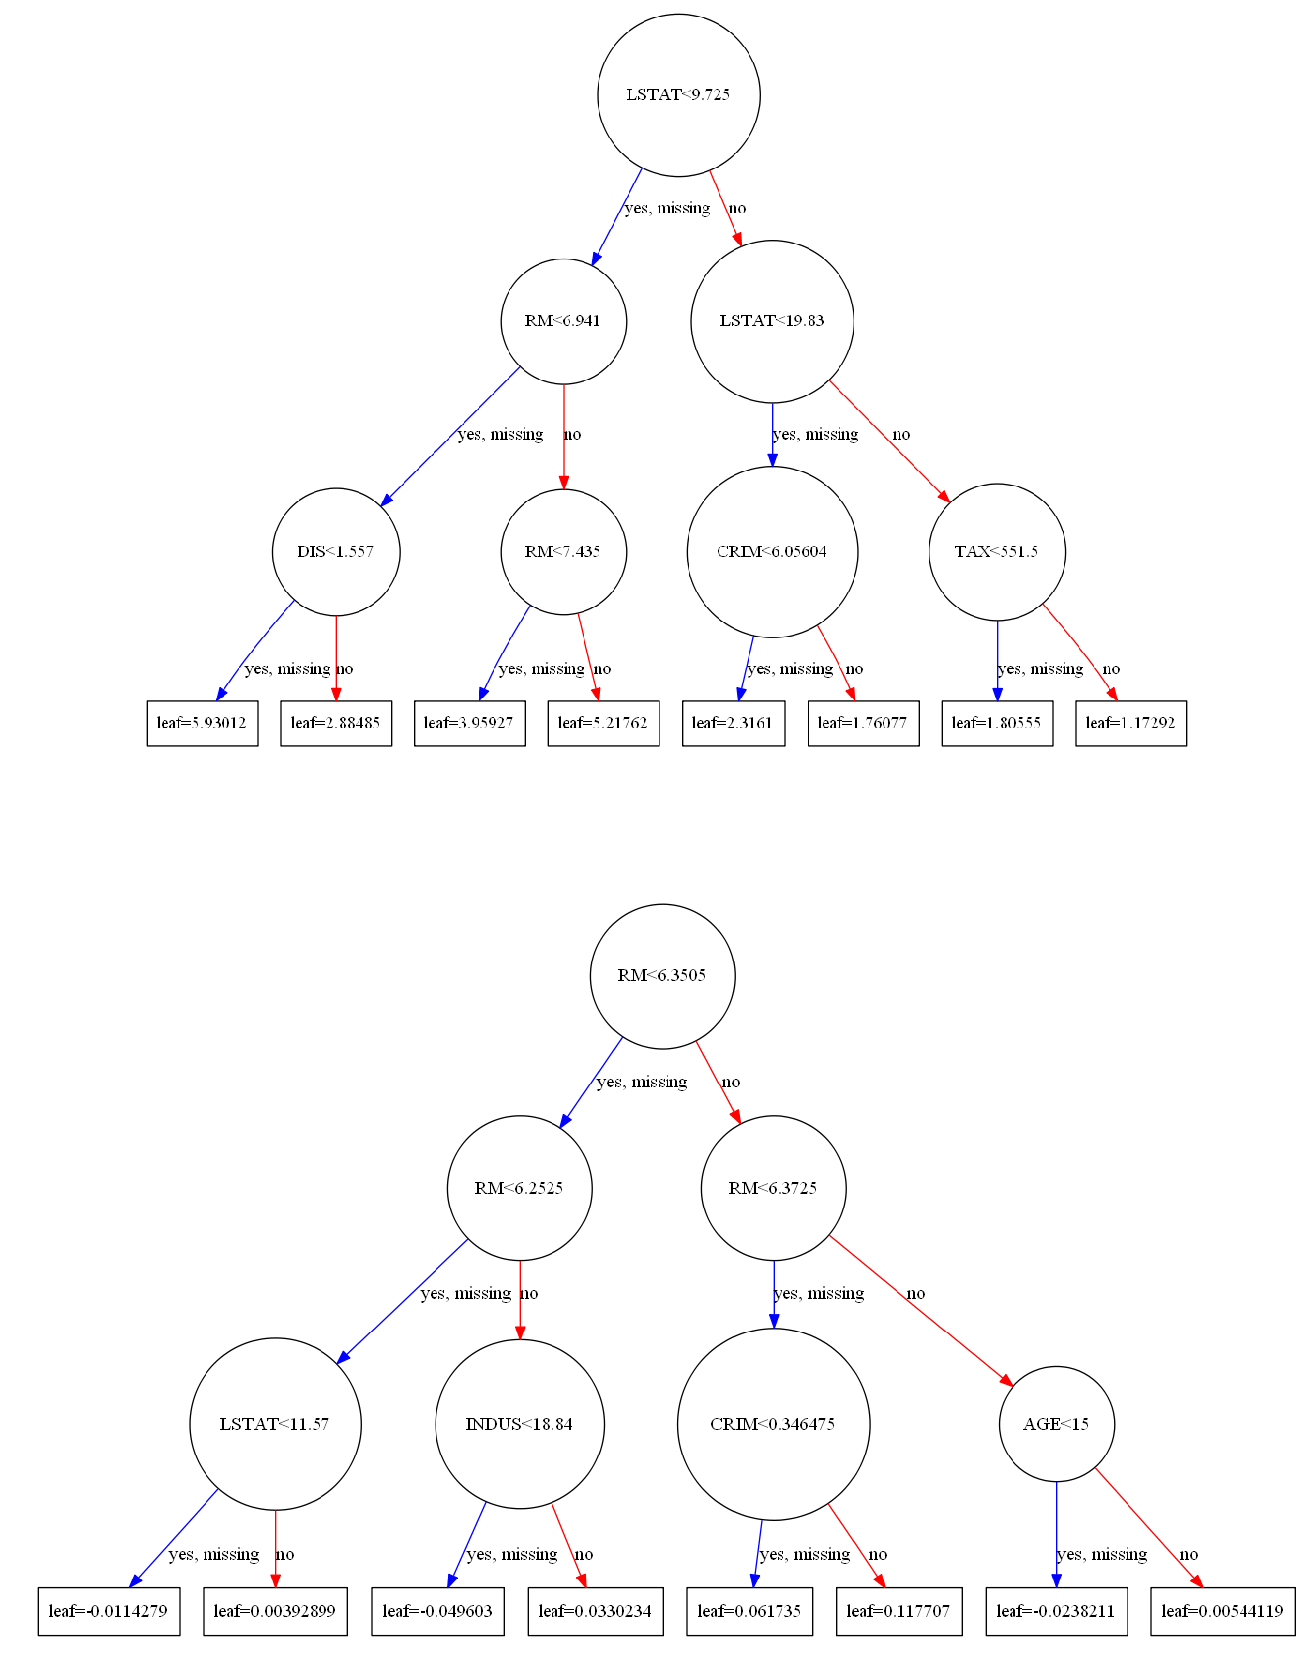

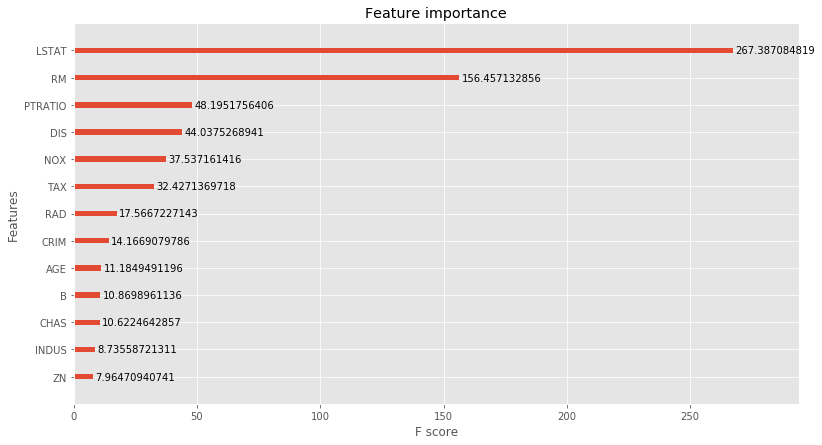

In [249]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'exact',
    'num_parallel_tree':1
}, dmat=DData)

(171, 4)


test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         20.717008       0.855364        20.704865        0.208794
1         18.351570       0.755902        18.309927        0.189723
2         16.282555       0.709452        16.199668        0.164555
3         14.478107       0.649345        14.355072        0.138693
4         12.907943       0.614919        12.731258        0.118575
166        3.251264       0.420848         0.653393        0.028601
167        3.249774       0.421091         0.649830        0.028769
168        3.250509       0.420694         0.646011        0.028645
169        3.250054       0.420157         0.642692        0.028718
170        3.249056       0.421410         0.638425        0.028888

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=171,
       n_jobs=1, nthread=None, num_parallel_tree=3, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=0.005, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.885, tree_method='exact')


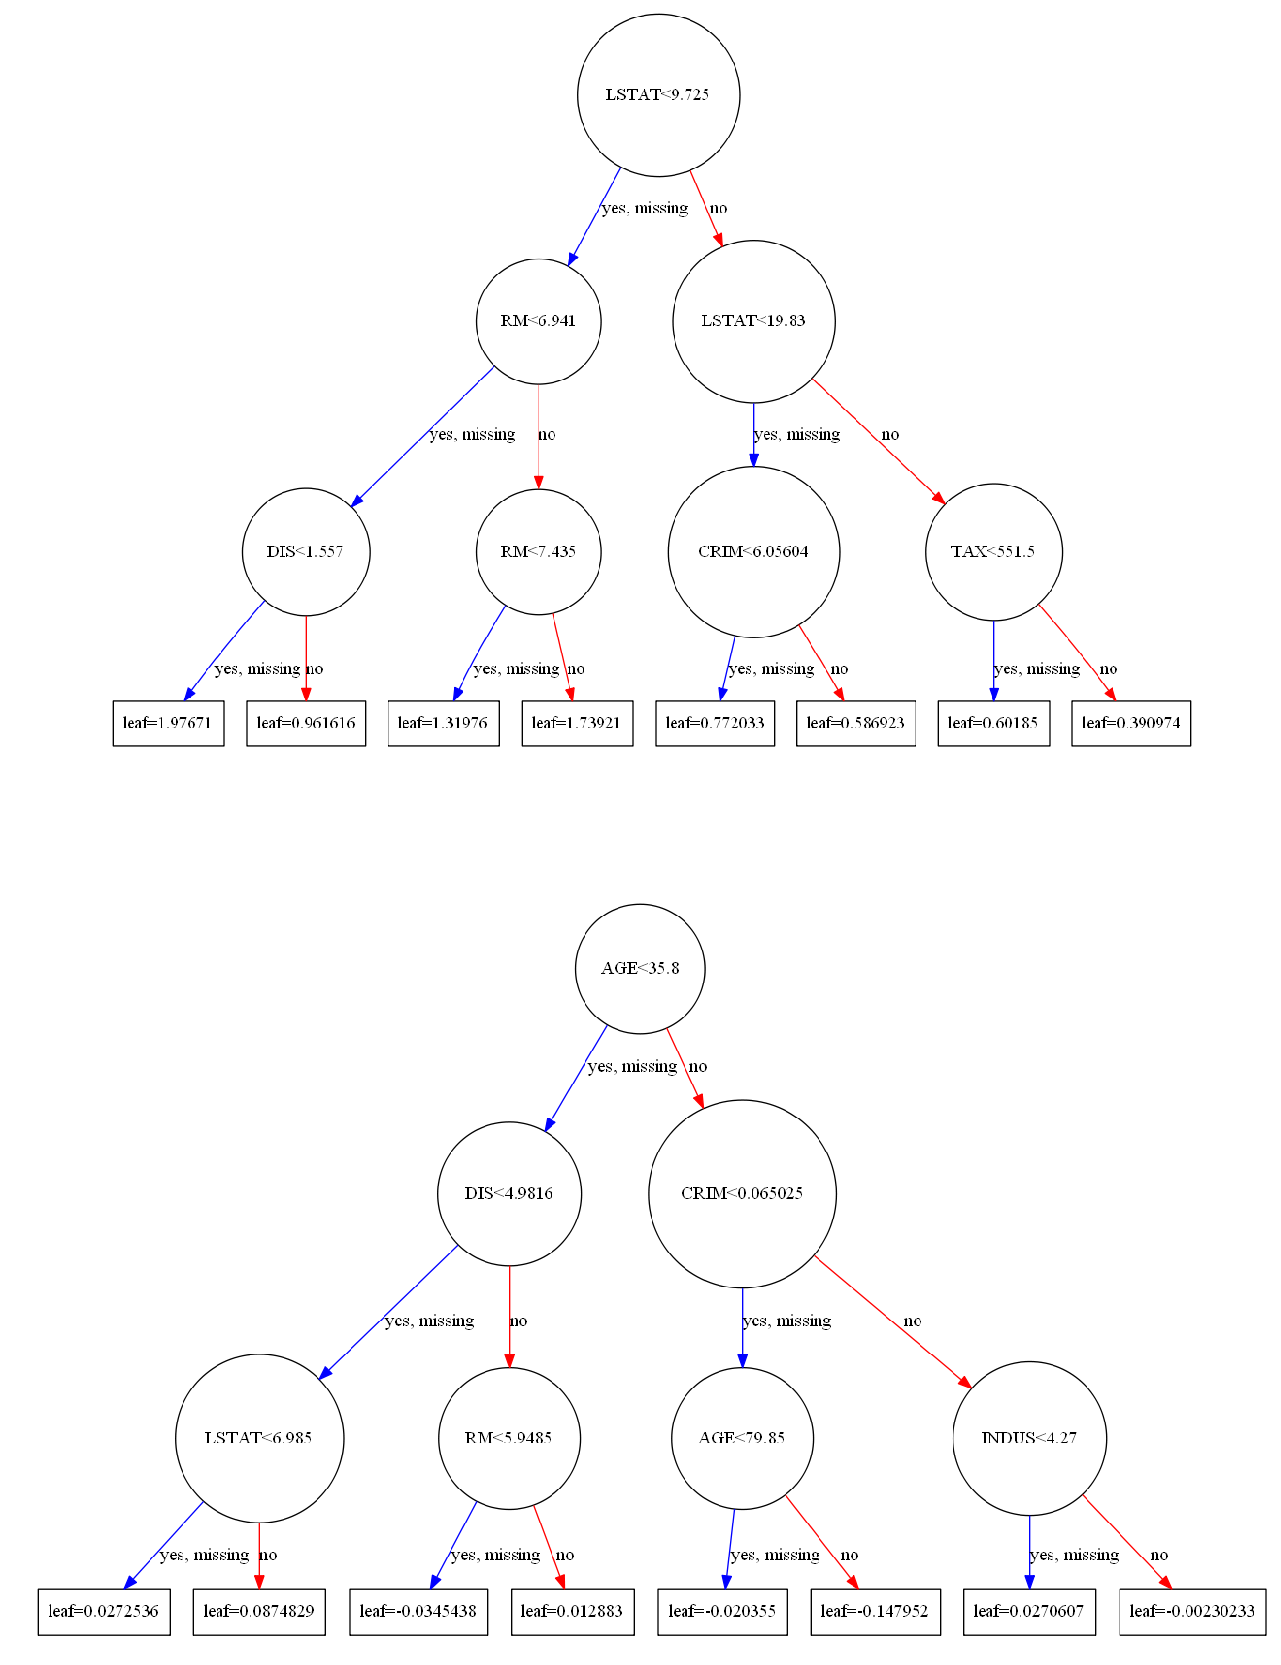

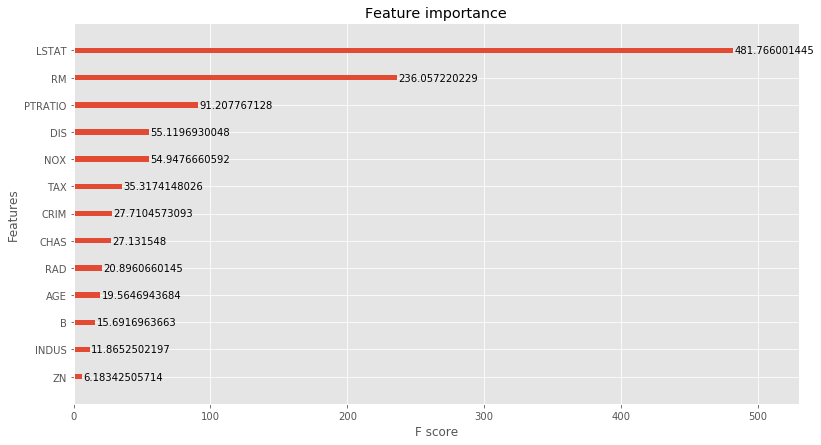

In [263]:
run_model_report(param={
    'learning_rate':0.12,
    'n_estimators':1000,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'exact',
    'num_parallel_tree':3
}, dmat=DData)

In [265]:
param={
    'learning_rate':0.12,
    'n_estimators':171,
    'max_depth':3,
    'min_child_weight':0,
    'gamma':0,
    'objective':'reg:linear',
    'subsample':0.885,
    'reg_lambda':0.005,
    'tree_method':'exact',
    'num_parallel_tree':3
}
model=xgb.XGBRegressor(**param)
model.fit(dfTrain, dfTrainLabel)
predictions = model.predict(dfTest)
actuals = dfTestLabel
print 'Test rmse:',RMSE(actuals, predictions)

Test rmse: 2.44231619059


In [271]:
len(model.get_booster().get_dump())

513

In [277]:
print model.get_booster().get_dump()[0]
print model.get_booster().get_dump()[1]
print model.get_booster().get_dump()[2]
print model.get_booster().get_dump()[3]

0:[LSTAT<9.725] yes=1,no=2,missing=1
	1:[RM<6.941] yes=3,no=4,missing=3
		3:[DIS<1.557] yes=7,no=8,missing=7
			7:leaf=1.97671
			8:leaf=0.961616
		4:[RM<7.435] yes=9,no=10,missing=9
			9:leaf=1.31976
			10:leaf=1.73921
	2:[LSTAT<19.83] yes=5,no=6,missing=5
		5:[CRIM<6.05604] yes=11,no=12,missing=11
			11:leaf=0.772033
			12:leaf=0.586923
		6:[TAX<551.5] yes=13,no=14,missing=13
			13:leaf=0.60185
			14:leaf=0.390974

0:[LSTAT<7.865] yes=1,no=2,missing=1
	1:[RM<7.435] yes=3,no=4,missing=3
		3:[RM<6.6805] yes=7,no=8,missing=7
			7:leaf=0.985757
			8:leaf=1.2686
		4:[CRIM<2.74224] yes=9,no=10,missing=9
			9:leaf=1.75884
			10:leaf=0.851741
	2:[LSTAT<19.83] yes=5,no=6,missing=5
		5:[DIS<1.2427] yes=11,no=12,missing=11
			11:leaf=1.97015
			12:leaf=0.777901
		6:[CRIM<7.53796] yes=13,no=14,missing=13
			13:leaf=0.567548
			14:leaf=0.360607

0:[LSTAT<9.725] yes=1,no=2,missing=1
	1:[RM<7.141] yes=3,no=4,missing=3
		3:[DIS<1.557] yes=7,no=8,missing=7
			7:leaf=1.97506
			8:leaf=1.00694
		4:[LST